In [55]:
#Radial velocity shifts from SALT spectral data imports

from PIL import Image
from IPython.display import display


# Open the PNG file
img = Image.open("/data/wdplanetary/omri/Output/Gaussianline/blue/MgII_4481/MgII_4481_2020-07-30 00:00:00.png")
display(img)

In [56]:
#importing
import numpy as np
import astropy.io.fits as fits
import matplotlib.pyplot as plt 
import pandas as pd
from astropy.stats import sigma_clip
from astropy.modeling import models,fitting
from scipy.ndimage import uniform_filter1d
from scipy.stats import norm
from scipy.special import voigt_profile
from scipy import signal
from scipy.signal import correlate
from PyAstronomy import pyasl
from scipy.optimize import curve_fit
from astropy.time import Time
import astropy.units as u
from astropy.coordinates import SkyCoord, EarthLocation
from astropy.constants import c
import astropy.io.fits as fits
from astropy.units import dimensionless_unscaled
from lmfit.models import LinearModel, GaussianModel, VoigtModel, PolynomialModel
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
import glob
import fnmatch
import os
from astropy.timeseries import LombScargle
from plotnine import *
import traceback
import sys
import linecache
import textwrap
import re
import emcee
import corner
import tqdm

""" 
plt.rcParams['axes.linewidth'] = 1.25
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 1.25
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1.25
 """
default_settings = {
    'font.size': 16,
    'axes.linewidth': 0.8,
    'xtick.major.size': 3.5,
    'xtick.major.width': 1,
    'ytick.major.size': 3.5,
    'ytick.major.width': 1
}


initial_settings = {
    'font.size': 22,
    'axes.linewidth': 1.25,
    'xtick.major.size': 5,
    'xtick.major.width': 1.25,
    'ytick.major.size': 5,
    'ytick.major.width': 1.25
}
plt.rcParams.update(default_settings)

In [57]:
#importing Mike data function


def read_mike_spec(filename):

    hdulist = fits.open(filename)
    obj_fits = hdulist[0]
    header = obj_fits.header
    date_obs = header.get('UT-DATE', None)
    time_obs = header.get('UT-START',None)
    
    OBJECT = header.get("OBJECT", None)
   
    sky_spec = obj_fits.data[0,:,:]
    obj_spec = obj_fits.data[1,:,:]
    noi_spec = obj_fits.data[2,:,:]
    snr_spec = obj_fits.data[3,:,:]
    lamp_spec = obj_fits.data[4,:,:]
    flat_spec = obj_fits.data[5,:,:]
    nobj_spec = obj_fits.data[6,:,:]
    hdulist.close()

    # Ca H and K are found in orders 18-22 which are indexed 17-21. Over these
    # 4 order, the extracted Ca H and K can be combined to further reduce noise
   
    i = 0
    found = -1
   
    while (found == -1) and (i < len(header)):
        found = str(header[i]).find('spec1')
        i += 1
   
    all_order_wav = str(header[(i-1)::])
    all_order_wav = '\''+all_order_wav
   
    #The following loop can be used to remove all the header keys from the string
    i = 1
    match = True
    while match:
        string = '\'WAT2_%03d= \'' % i
        wat = re.compile(string)
        match = wat.search(all_order_wav)
        all_order_wav = wat.sub('',all_order_wav)
        i +=1
   
    wavelength_soln_data = []
   
    #This loop parses the wavelength solns by the spec keyword and stores the entire
    #solution as a list of lists, each entry containing one place for each solved
    #parameter.
    i = 1
    match = True
    while match:
        string = 'spec%d' %i
        spec_key = re.compile(string)
        match = spec_key.search(all_order_wav)
        if match:
            wavelength_soln_data.append((all_order_wav[(match.start()+10):match.start()+91]).split())
        i+=1
   
    #This loop generates an array of arrays with each array containing the wavelength
    #soln.
    wav_solns = []
    for i in range(len(wavelength_soln_data)):
        wav_start = float(wavelength_soln_data[i][3])
        wav_delta = float(wavelength_soln_data[i][4])
        wav_end = wav_start + wav_delta*float(wavelength_soln_data[i][5])
        wav_solns.append(np.arange(wav_start,wav_end,wav_delta))
        i+=1
    #    
    #    plt.figure(1)
    #    plt.clf()
    #    for i in range(len(wav_solns)):
    #        plt.plot(wav_solns[i],nobj_spec[i,:])
       
    all_data = np.zeros([len(wav_solns),9],dtype=object)
    for i in range(len(wav_solns)):
        all_data[i,0] = i+1
        all_data[i,1] = wav_solns[i]
        all_data[i,2] = sky_spec[i,:]
        all_data[i,3] = obj_spec[i,:]
        all_data[i,4] = noi_spec[i,:]
        all_data[i,5] = snr_spec[i,:]
        all_data[i,6] = lamp_spec[i,:]
        all_data[i,7] = flat_spec[i,:]
        all_data[i,8] = nobj_spec[i,:]
    keywords = ['Order','Wavelength Soln', 'Sky Spectrum', 'Object Spectrum',
                'Noise Spectrum', 'SNR Spectrum', 'Lamp Spectrum', 'Flat Spectrum',
                'Normalized Object Spectrum']


    #First, calculating the heliocentric correction

    site_lat = header.get("SITELAT",None)
    site_long = header.get("SITELONG",None)
    site_alt = header.get("SITEALT",None)
    ra = header.get("RA-D",None)  # in degrees
    dec = header.get("DEC-D", None)  # in degrees
    epoch = str(header.get("EPOCH", None))  # e.g., 'J2000'
    time = Time(str(date_obs) + 'T' + str(time_obs), format='fits',scale = "utc")
    
    #print(time)
    # Create EarthLocation object
    location = EarthLocation.from_geodetic(lat=site_lat*u.deg, lon=site_long*u.deg, height=site_alt*u.m)
    sc = SkyCoord(ra=ra*u.deg, dec=dec*u.deg)
    heliocorr = sc.radial_velocity_correction('heliocentric', obstime=time, location=location) 
    #print(heliocorr.to(u.km/u.s)) 
    heliocorr = (heliocorr.to(u.m/u.s) /c)


    
    #Now making easy arrays to use:
    wav = []
    order= []
    flux = []
    snr = []
    for i in range(len(all_data)):
        wav.append(all_data[i,1])
        order.append(all_data[i,0])
        flux.append(all_data[i,8])
        snr.append(all_data[i,5])


    #Now apply the heliocentric correction to the wavelength data:
    for i in range(len(wav)):
        for jk in range(len(wav[i])):
            wav[i][jk] *= (1 + heliocorr)

        #heliocentric correction
     #   wavelength[i] = (CRVAL1 + CDELT1*i) + (HEL_COR/299792 )*(CRVAL1 + CDELT1*i)
        #wavelength[i] = (CRVAL1 + CDELT1*i)
    
    return order,wav,flux,snr, OBJECT,time



#filename = "/data/wdplanetary/laura/MIKE/Data/WD1929+011/blue/galex1931_blue_2011-06-09.fits"
""" order,wav,flux,snr,OBJECT,time = read_mike_spec(filename)
long_string = str(header)
wrapped_text = textwrap.wrap(long_string, width=80)
for line in wrapped_text:
    print(line)
plt.figure()
plt.plot(wav[8],flux[8])
plt.xlim(4475,4485)
plt.show()

plt.figure()
plt.plot(wav[8],snr[8])
plt.xlim(4475,4485)
plt.show() """



' order,wav,flux,snr,OBJECT,time = read_mike_spec(filename)\nlong_string = str(header)\nwrapped_text = textwrap.wrap(long_string, width=80)\nfor line in wrapped_text:\n    print(line)\nplt.figure()\nplt.plot(wav[8],flux[8])\nplt.xlim(4475,4485)\nplt.show()\n\nplt.figure()\nplt.plot(wav[8],snr[8])\nplt.xlim(4475,4485)\nplt.show() '

In [58]:
#salt read in data
def Get_Wavelength_Flux_File(filename) :
    # Get the wavelength and flux from a MIDAS pipeline file
    hdulist = fits.open(filename)
    header = hdulist[0].header
    date_obs = header.get('DATE-OBS', None)
    time_obs = header.get('TIME-OBS',None)
    time = Time(str(date_obs) + 'T' + str(time_obs), format='fits')
    #time = Time(date_obs,format = "fits")
    
    flux = hdulist[0].data # flux in counts 
    
    CRVAL1 = hdulist[0].header['CRVAL1'] # Coordinate at reference pixel
    CRPIX1 = hdulist[0].header['CRPIX1'] # Reference pixel
    CDELT1 = hdulist[0].header['CDELT1'] # Coordinate increase per pixel
    HEL_COR = hdulist[0].header['HEL_COR'] # Heliocentric correction
    OBJECT = str(header.get("OBJECT", None))
    
    # Need to use the info above to make the wavelength axis
    wavelength = np.zeros(len(flux))
    print(f"The reference pixel in timefile: {time} is {CRPIX1}")
    for i in range(len(wavelength)) :
        #heliocentric correction
        wavelength[i] = (CRVAL1 + CDELT1*i) + (HEL_COR/299792 )*(CRVAL1 + CDELT1*i) - (CRPIX1*CDELT1)
        #wavelength[i] = (CRVAL1 + CDELT1*i)
    
    hdulist.close()	

    return wavelength, flux, time, OBJECT

In [59]:
io_noise = []

#dictionary for all the inter-order noise areas for the SALT blue spectrum
#manually removing them
io_noise.append((3890,3910))
io_noise.append((3890,3910))
io_noise.append((3934,3945))
io_noise.append((3960,3972))
io_noise.append((3995,4010))
io_noise.append((4030,4040))
io_noise.append((4063,4075))
io_noise.append((4103,4115))
io_noise.append((4140,4150))
io_noise.append((4175,4185))
io_noise.append((4175,4185))
io_noise.append((4215,4225))
io_noise.append((4175,4185))
io_noise.append((4255,4265))
io_noise.append((4290,4305))
io_noise.append((4330,4345))
io_noise.append((4370,4382))
io_noise.append((4415,4428))
io_noise.append((4455,4470))
io_noise.append((4495,4510))
io_noise.append((4545,4555))
io_noise.append((4455,4470))
io_noise.append((4585,4600))
io_noise.append((4633,4650))
io_noise.append((4680,4690))
io_noise.append((4728,4740))
io_noise.append((4777,4790))
io_noise.append((4826,4835))
io_noise.append((4878,4888))
io_noise.append((4928,4938))
io_noise.append((4980,4988))
io_noise.append((5032,5050))
io_noise.append((5080,5100))
io_noise.append((5148,5158))
io_noise.append((5208,5215))
io_noise.append((5265,5275))
io_noise.append((5325,5335))
io_noise.append((5325,5335))
io_noise.append((5385,5395))
io_noise.append((5400,5600)) #big cut off for second channel (red)
io_noise.append((5625,5635))
io_noise.append((5695,5705))
io_noise.append((5765,5779))


hdulist = fits.open("/data/wdplanetary/omri/Data/WD1929+012/2017-1-SCI-031.20170706/product/mbgphH201707060019_u2wm.fits")
header = hdulist[0].header
print(header)

In [61]:
#line dictionaries: Name, position(A), present?, log gf
p_lines = []
spec_lines = []

#pollutant lines
p_lines.append(("CaII_3933", 3933.663, True)) #only use for MIKE data
p_lines.append(("CaII_4226",4226.727, False)) #good
p_lines.append(("FeII_4923",4923.927, False)) #can't use, crosses over with interorder
p_lines.append(("FeII_5018",5018.440, False))#not there
p_lines.append(("FeII_5169",5169.033, False)) #this one gives an error when trying to fit it
p_lines.append(("SiII_5041",5041.024, False)) #don't use this
p_lines.append(("SiII_5055",5055.984, False) #This one is good use it
p_lines.append(("SiII_5957",5957.560, False))
p_lines.append(("SiII_5978",5978.930, False))
p_lines.append(("SiII_6347",6347.100, False)) #these two are quite strong in WD1929+012
p_lines.append(("SiII_6371",6371.360, False)) #
p_lines.append(("MgI_5172",5172.683, False))
p_lines.append(("MgI_5183",5183.602, False))
p_lines.append(("MgII_4481",4481.130,False)) #strong magnesium line
p_lines.append(("MgII_4481_2",4481.327, False))
p_lines.append(("MgII_4481",4481.180,False)) #weighted combination of mg_4481 lines

p_lines.append(("MgII_7877",7877.054, False)) 
p_lines.append(("MgII_7896",7896.366, False)) #definitely not present
p_lines.append(("OI_7771",7771.944, False)) #definitely not present
#hydrogen lines
p_lines.append(("H_4860",4860.680, False))
p_lines.append(("H_4860_2",4860.968, False))#This one gives better values
p_lines.append(("H_4860_2",4860.968, False))#Weighted combo
p_lines.append(("H_4340",4340.472,False)) #present
p_lines.append(("H_6563",6562.79 ,False)) 
#pick the spectral lines present in this white dwarf

for i in p_lines:
    if i[2] == True:
        spec_lines.append(i)

b_lines = []
r_lines = []
for i in spec_lines:
    if i[1] <= 5550:
        #370 - 555 nm
        b_lines.append(i)
    else:
        #555 - 890 nm
        r_lines.append(i)

#Now define the sky lines that we will use to find the stability corrections from the instrument variability

sky_lines = []
sky_lines.append(("OI_5577",5577.340))
sky_lines.append(("OI_6300",6300.304))
sky_lines.append(("OI_6364",6363.776))
#sky_lines.append(("H2O_7392"))
#sky_lines.append(("H2O_8365"))


SyntaxError: invalid syntax (<ipython-input-61-3cb32f3b9f6e>, line 13)

for i in b_files:
    print(i)

The reference pixel in timefile: 2020-07-27T21:36:08.351 is -993.0
SIMPLE  =                    T / Standard FITS format: NOST 100-2.0
BITPIX  =                  -32 / No. of bits per pixel
NAXIS   =                    1 / No. of axes in image
NAXIS1  =                80401 / No. of pixels
EXTEND  =                    T / FITS extension may be present
COMMENT NOST 100-2.0: Hanisch,R. et al. 2001, Astron. & Astrophys. 376, 559
CRPIX1  =               -1024. / Reference pixel
CRVAL1  =        5417.54518914 / Coordinate at reference pixel
CDELT1  =         0.0414179079 / Coord. incr. per pixel (original value)
CTYPE1  = 'WAVELENGTH      '   / Units of coordinate
BUNIT   = 'FLUX            '   / Units of data values
DATAMAX =     0.00551992096007 / Maximum data value
DATAMIN =     -0.0309941023588 / Minimum data value
ORIGIN  = 'ESO-MIDAS'          / Written by MIDAS
DATE    = '2021-04-21T09:02:30' /  [UTC] Date of writing
FILENAME= 'Obj_LR_Rrb_emude.bdf' / Original file base-name
MIDASFTP

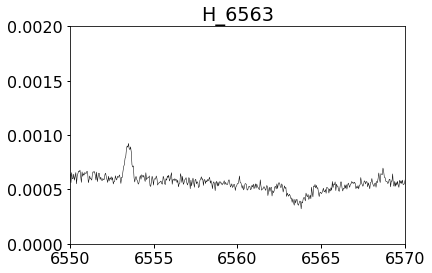

In [ ]:

wav,flux,time,OBJECT = Get_Wavelength_Flux_File("/data/wdplanetary/omri/Data/WD1929+012/2019-2-SCI-049.20200727/product/mbgphR202007270042_u2wm.fits")
plt.figure(facecolor="white")
plt.plot(wav, flux, color='black', linewidth=0.5)
plt.title(f"{i[0]}")
plt.xlim(6550,6570)
plt.ylim(0,0.002)
plt.show 


hdulist = fits.open("/data/wdplanetary/omri/Data/WD1929+012/2019-2-SCI-049.20210420-2/product/mbgphR202104200024_uwm.fits")
header = hdulist[0].header


long_string = str(header)
wrapped_text = textwrap.wrap(long_string, width=80)
for line in wrapped_text:
   print(line)

date_obs = header.get('DATE-OBS', None)
time = Time(date_obs, format='fits')
star = header.get("OBJECT", None)
print(str(star))
#print(time)
hdulist.close()

# Print the UTC representation of the time
#print(f"Observation Date and Time (UTC): {time.utc.iso}")

In [ ]:
#function to process the inputted wavelength and flux data, 
#making binary masks, moving averagses, normalising the continuum

def process_data_gaussian(wav,flux):
    
    #make a new wavelength filter that is accurate to 3dp
    min = wav[np.argmin(wav)]
    max = wav[np.argmax(wav)]
    xwav = np.arange(min,max,0.001)

    # Adjust the size of the flux data to fit the mask
    interp_func = interp1d(wav, flux, bounds_error=False, fill_value=np.nan)
    padded_flux = interp_func(xwav)

    #movingavg
    window_size = 3000
    n_moving_avg = uniform_filter1d(padded_flux, size=window_size)
    
    return xwav,padded_flux,n_moving_avg


    


In [ ]:
#function to process the inputted wavelength and flux data, 
#making binary masks, moving averagses, normalising the continuum

def process_data_cc(wav,flux):

    #smoothing data
    s_flux = savgol_filter(flux, window_length=501, polyorder=3)
    flux = flux/s_flux
    
    #interpolating for the interorder noise
    
    #for i in io_noise:
    #    a = np.searchsorted(wav, i[0])
    #    b = np.searchsorted(wav, i[1])
    #    flux[a:b] = np.nan
 
    #not_nan = np.where(~np.isnan(flux))[0]
    #x = np.arange(flux.shape[0])
    #flux[np.isnan(flux)] = np.interp(x[np.isnan(flux)], not_nan, flux[not_nan])

    #make a new binary mask that is accurate to 3dp
    #xwav = np.arange(3857.2,8871.2,0.001)
    #mask = np.zeros(len(xwav))
    #mask[:]=1

    #adjust the size of the flux data to fit the mask
    #padded_flux = np.interp(xwav, wav, flux)
    
    #normalise the continuum
    #smoothed_continuum = savgol_filter(flux, window_length=501, polyorder=3)
    #n_flux = flux / smoothed_continuum
    #n_p_flux = padded_flux / smoothed_continuum

    # Adjust the size of the flux data to fit the mask
    #interp_func = interp1d(wav, flux, bounds_error=False, fill_value=np.nan)
    #padded_flux = interp_func(xwav)

    # Normalise the continuum using Savitzky-Golay filter
    #smoothed_continuum = savgol_filter(padded_flux, window_length=2001, polyorder=3)
    #n_p_flux = np.nan_to_num(padded_flux/smoothed_continuum, nan=1, posinf=1, neginf=1)

    # Clip values to the bound
    #bound = 2
    #n_p_flux = np.clip(n_p_flux, -bound, bound)

    #also maybe we could make a mask that is basically a moving average of the spectrum 
    #over a very wide moving average?
    #window_size = 30000
    #n_moving_avg = uniform_filter1d(padded_flux, size=window_size)

    #dw_masked = np.ma.masked_invalid(wav)
    #df_masked = np.ma.masked_invalid(s_flux)

    # Get masked arrays with NaN excluded
    #dw_comp = dw_masked.compressed() 

    # Get valid (non NaN) indices  
    #valid_ind = ~np.isnan(flux)
    #wav = wav[valid_ind]
    #flux = flux[valid_ind]

    
    
    return wav,flux #,xwav,padded_flux,n_moving_avg n_mask


    


In [ ]:
def process_data_model(wav,flux,c_lines):
    u_loc = np.searchsorted(wav, (5200))
    closest_value = wav[max(0, u_loc-1)]
    u_bound = np.where(wav == closest_value)
    u_bound = int(u_bound[0])
    #find the lower bound of the window
    l_loc = np.searchsorted(wav, (4100))
    closest_value = wav[max(0, l_loc-1)]
    l_bound = np.where(wav == closest_value)
    l_bound = int(l_bound[0])
    #make small datasets around the window
    flux = flux[l_bound:u_bound]
    wav = wav[l_bound:u_bound]


    #interpolate the spectrum to make it more detailed
    minimum = wav[np.argmin(wav)]
    maximum = wav[np.argmax(wav)]
    xwav = np.arange(minimum,maximum,0.01)

    # Adjust the size of the flux data to fit the mask
    interp_func = interp1d(wav, flux, bounds_error=False, fill_value=np.nan)
    padded_flux = interp_func(xwav)
    

    #normalise the continuum
    s_flux = savgol_filter(padded_flux, window_length=501, polyorder=4)

    n_flux = padded_flux / s_flux

    #n_flux = flux
    


    #now add voight profiles to the continuum where the lines should be:
    # Add a Voigt profile for each line -
    #we need to check the outputted voigt parameters for the direct Voigt fits and use these
    for i in c_lines:
    #Mg4481 line
        center = float(i[1])
        amplitude = -0.05
        sigma =  0.3
        gamma = 0.1
        model = VoigtModel()
        #print((model.func(wav, amplitude, center, sigma, gamma)))
        n_flux -= 4 * np.abs(model.func(xwav, amplitude, center, sigma,gamma))

    return xwav,n_flux

#wav,n_flux = process_data_model(model_wav,model_flux,b_lines)
#plt.plot(wav,n_flux)
#plt.ylim(0,4)
#plt.xlim(4100,5200)
#plt.show()
    

In [ ]:
def process_data_mike_gaussian(wav,flux,c_lines):
    #make a new wavelength filter that is accurate to 3dp
    min = wav[np.argmin(wav)]
    max = wav[np.argmax(wav)]
    xwav = np.arange(min,max,0.001)

    minlen = np.minimum(len(wav),len(flux))

    # Adjust the size of the flux data to fit the mask
    interp_func = interp1d(wav[:minlen], flux[:minlen], bounds_error=False, fill_value=np.nan)
    padded_flux = interp_func(xwav)

    #movingavg
    window_size = 3000
    n_moving_avg = uniform_filter1d(padded_flux, size=window_size)
    return xwav, padded_flux, n_moving_avg

In [ ]:
#calculate errors - faster

 #In raw data points

def calculate_error(data):
    window_size = int(500)
    # Use a rolling window approach for efficient calculation of standard deviation
    #least mean squared method
    rolling_std = np.sqrt(np.convolve(data**2, np.ones(window_size) / window_size, mode='valid') - np.convolve(data, np.ones(window_size) / window_size, mode='valid')**2)
    
    # Extend the result to match the original length of the data
    pad_width = window_size // 2
    errors = np.pad(rolling_std, (pad_width, pad_width), mode='edge')
    #print(len(errors),len(data))
    errorsv = np.nan_to_num(errors)
    #print(np.mean(errorsv))
    return errorsv[:len(data)]



#Currently using a window size of 100 - better representing the individual variation
#Also currently multiplying the raw error figure in the data by 5 to try and get a more representative result

In [ ]:
def poly_fit(gwav,gdata):
    poly_model = PolynomialModel(degree=7)
    params = poly_model.guess(gdata, x=gwav)
    poly_result = poly_model.fit(gdata, params, x=gwav)
    print(poly_result.params['c0'],poly_result.params['c1'],poly_result.params['c2'],poly_result.params['c3'],poly_result.params['c4'])
    
    #find the individual polynomial best fit
    c0 = poly_result.params['c0'].value
    c1 = poly_result.params['c1'].value
    c2 = poly_result.params['c2'].value
    c3 = poly_result.params["c3"].value
    c4 = poly_result.params["c4"].value
    c5 = poly_result.params["c5"].value
    c6 = poly_result.params["c6"].value
    c7 = poly_result.params["c7"].value
    
    p_result = c0 + c1 * gwav + c2 * gwav**2 + c3 * gwav**3 + c4 * gwav**4 + c5 * gwav**5 + c6 * gwav**6 + c7 * gwav**7

    plt.figure()
    plt.plot(gwav, p_result, color='green', linewidth=1)
    plt.plot(gwav, gdata, color='blue', linewidth=0.5)
    
    plt.show()
    return p_result

In [ ]:
#function to pick the files that we want

def pick_files_by_patterns(folder_path, start_patterns, end_patterns):
    """
    Pick files in a folder based on given start and end patterns in their filename.

    Parameters:
    - folder_path (str): Path to the folder containing files.
    - start_patterns (list): List of patterns to match at the start of filenames.
    - end_patterns (list): List of patterns to match at the end of filenames.

    Returns:
    - List of filenames matching the specified start and end patterns.
    """
    matching_files = []

    # Ensure the folder path is valid
    if not os.path.isdir(folder_path):
        print(f"Error: {folder_path} is not a valid directory.")
        return matching_files

    for folder_name in os.listdir(folder_path):
        fp = os.path.join(folder_path, folder_name,"product/")

        # List all files in the folder
        try:
            all_files = os.listdir(fp)
        except FileNotFoundError:
            continue
        except NotADirectoryError:
            continue

        # Filter files based on start patterns
        #for start_pattern in start_patterns:
        #   matching_files.extend(fnmatch.filter(all_files, start_pattern + '*'))

        # Filter files based on end patterns
        #for end_pattern in end_patterns:
         #   matching_files.extend(fnmatch.filter(all_files, '*' + end_pattern))
        for file in all_files:
            if file.startswith(start_patterns) and file.endswith(end_patterns):
                matching_files.append(os.path.join(fp, file))

    return matching_files


def mike_pick_files_by_patterns(folder_path, start_patterns, end_patterns):
    matching_files = []
    # Ensure the folder path is valid
    if not os.path.isdir(folder_path):
        print(f"Error: {folder_path} is not a valid directory.")
        return matching_files
    try:
        for file_name in os.listdir(folder_path):
            matching_files.append(os.path.join(folder_path, file_name))
    except FileNotFoundError:
        # Handle the case where the folder doesn't exist
        print(f"The folder '{folder_path}' does not exist.")
        return None
    
    # Return the list of matching files
    return matching_files

# Example usage:

#This is where we pick the folder path and the name of the file that we want
#Need to adjust this so that it is more clear
star = "WD1929+012"
SALT_folder_path = "/data/wdplanetary/omri/Data/WD1929+012/"
MIKE_blue_folder_path = "/data/wdplanetary/laura/MIKE/Data/WD1929+011/blue/"
MIKE_red_folder_path = "/data/wdplanetary/laura/MIKE/Data/WD1929+011/red/"


blue_start = ("mbgphH")
red_start =  ("mbgphR")
end_patterns = ("u2wm.fits")  #End pattern for the object fiber
sky_end_patterns = ("u1wm.fits") #End pattern for the sky fiber
merged_end_patterns = ("uwm.fits") #end pattern for the reduced fiber
mike_start = ("gal")
mike_end = (".fits")

#Creating file directory for the blue and red channels separately
b_files = pick_files_by_patterns(SALT_folder_path, blue_start, end_patterns)
merged_b_files = pick_files_by_patterns(SALT_folder_path, blue_start, merged_end_patterns)
r_files = pick_files_by_patterns(SALT_folder_path, red_start, end_patterns)
sky_r_files = pick_files_by_patterns(SALT_folder_path, red_start, sky_end_patterns)
mike_b_files = mike_pick_files_by_patterns(MIKE_blue_folder_path, mike_start,mike_end)
mike_r_files = mike_pick_files_by_patterns(MIKE_red_folder_path, mike_start,mike_end)

b_files.sort()
r_files.sort()
sky_r_files.sort()
mike_b_files.sort()
mike_r_files.sort()
bad_date = ['/data/wdplanetary/omri/Data/WD1929+012/2019-1-SCI-008.20190513',
            '/data/wdplanetary/omri/Data/WD1929+012/2020-1-SCI-043.20200531',
            '/data/wdplanetary/omri/Data/WD1929+012/2018-1-SCI-043.20180605',
            '/data/wdplanetary/omri/Data/WD1929+012/2019-2-SCI-049.20200824',
            '/data/wdplanetary/omri/Data/WD1929+012/2017-1-SCI-031.20170813/product/mbgphH20170813003'
            ]

b_files = [f for f in b_files if not any(f.startswith(start) for start in bad_date)]
r_files = [f for f in r_files if not any(f.startswith(start) for start in bad_date)] 
sky_r_files = [f for f in sky_r_files if not any(f.startswith(start) for start in bad_date)] 
merged_b_files = [f for f in merged_b_files if not any(f.startswith(start) for start in bad_date)]


In [ ]:
for i in mike_r_files:
    print(i)

/data/wdplanetary/laura/MIKE/Data/WD1929+011/red/gal1931+011_red_2010-07-08.fits
/data/wdplanetary/laura/MIKE/Data/WD1929+011/red/galex1931_red_2010-06-16.fits
/data/wdplanetary/laura/MIKE/Data/WD1929+011/red/galex1931_red_2010-06-17.fits
/data/wdplanetary/laura/MIKE/Data/WD1929+011/red/galex1931_red_2010-08-02.fits
/data/wdplanetary/laura/MIKE/Data/WD1929+011/red/galex1931_red_2010-08-03.fits
/data/wdplanetary/laura/MIKE/Data/WD1929+011/red/galex1931_red_2011-06-09.fits


In [ ]:
for i in r_files:
    print(i)

/data/wdplanetary/omri/Data/WD1929+012/2017-1-SCI-031.20170706/product/mbgphR201707060019_u2wm.fits
/data/wdplanetary/omri/Data/WD1929+012/2017-1-SCI-031.20170706/product/mbgphR201707060020_u2wm.fits
/data/wdplanetary/omri/Data/WD1929+012/2017-1-SCI-031.20170706/product/mbgphR201707060021_u2wm.fits
/data/wdplanetary/omri/Data/WD1929+012/2017-1-SCI-031.20170711/product/mbgphR201707110019_u2wm.fits
/data/wdplanetary/omri/Data/WD1929+012/2017-1-SCI-031.20170711/product/mbgphR201707110020_u2wm.fits
/data/wdplanetary/omri/Data/WD1929+012/2017-1-SCI-031.20170711/product/mbgphR201707110021_u2wm.fits
/data/wdplanetary/omri/Data/WD1929+012/2017-1-SCI-031.20170714/product/mbgphR201707140017_u2wm.fits
/data/wdplanetary/omri/Data/WD1929+012/2017-1-SCI-031.20170714/product/mbgphR201707140018_u2wm.fits
/data/wdplanetary/omri/Data/WD1929+012/2017-1-SCI-031.20170714/product/mbgphR201707140019_u2wm.fits
/data/wdplanetary/omri/Data/WD1929+012/2017-1-SCI-031.20170722/product/mbgphR201707220017_u2wm.fits


In [ ]:
#Splitting files up in to boxes
def splitfiles(wavelength,flux):
    #l= 2
    l = abs(np.ptp(wavelength)/600)
    wavboxes = np.array_split(wavelength, l)
    fluxboxes = np.array_split(flux, l)
    return wavboxes,fluxboxes

#Split files into mini boxes around each line
def split_files_by_line(xwav,flux,line,w_size):
    #find the upper bound of the window
    line = float(line)
    u_loc = np.searchsorted(xwav, (line+(w_size/2)))
    closest_value = xwav[max(0, u_loc-1)]       
    u_bound = np.where(xwav == closest_value)
    u_bound = int(u_bound[0])       
    #find the lower bound of the window
    l_loc = np.searchsorted(xwav, (line-(w_size/2)))
    closest_value = xwav[max(0, l_loc-1)]
    l_bound = np.where(xwav == closest_value)
    l_bound = int(l_bound[0])
    #make small datasets around the line
    gdata = flux[l_bound:u_bound]
    gwav = xwav[l_bound:u_bound]
    return gwav,gdata

#making windows and bounds
def make_window(xwav,flux,errors,moving_avg,i,w_size):
#find the upper bound of the window
    u_loc = np.searchsorted(xwav, (i[1]+(w_size/2)))
    closest_value = xwav[max(0, u_loc-1)]
    u_bound = np.where(xwav == closest_value)
    u_bound = int(u_bound[0])
    #find the lower bound of the window
    l_loc = np.searchsorted(xwav, (i[1]-(w_size/2)))
    closest_value = xwav[max(0, l_loc-1)]
    l_bound = np.where(xwav == closest_value)
    l_bound = int(l_bound[0])
    #make small datasets around the line
    gdata = flux[l_bound:u_bound]
    gwav = xwav[l_bound:u_bound]
    gavg = moving_avg[l_bound:u_bound]
    gavg = np.where(gavg != 0, gavg, 1)
    #make a new window for errors which is just outside the window - basically the next window down instead
    #Instead we want to make a small window around the absorption line 
    #and then take the errors from the points around it 
    #and then take the average value of that 
    #and set the errors of the line to it
    el_loc = np.searchsorted(xwav, (i[1]-(1/10)*(w_size)))
    closest_value = xwav[max(0, el_loc-1)]
    el_bound = np.where(xwav == closest_value)
    el_bound = int(el_bound[0])
    eh_loc = np.searchsorted(xwav, (i[1]+(1/10)*(w_size)))
    closest_value = xwav[max(0, eh_loc-1)]
    eh_bound = np.where(xwav == closest_value)
    eh_bound = int(eh_bound[0])

    firsterrorbox = (errors[l_bound:el_bound])
    seconderrorbox = (errors[eh_bound:u_bound])
    err_avg = (np.mean(firsterrorbox) + np.mean(seconderrorbox) )/2
    lineerroravg= []*(eh_bound-el_bound)
    lineerroravg[el_bound:eh_bound] = [err_avg] * (eh_bound - el_bound)

    gerrors = np.concatenate((firsterrorbox, lineerroravg, seconderrorbox))
    #gerrors[np.isnan(gerrors)] = 0.001
    #gerrors[:len(gdata)]
    
    gweights = np.where(gerrors != 0, 1 / gerrors, 0.001)
    
    
    # Calculate the mean signal
    if l_bound < el_bound and eh_bound < u_bound:
        signal_mean = (np.mean(flux[l_bound:el_bound]) + np.mean(flux[eh_bound:u_bound])) / 2 - np.min(flux[el_bound:eh_bound])
    else:
        signal_mean = 10
    # Calculate the line depth
    depth = signal_mean / err_avg
    

    #now calculate snr
    snr = np.median(flux[l_bound:el_bound])/(np.std(flux[l_bound:el_bound]))


    return (gwav,gdata,gerrors,gweights,depth,snr)
    


#Laura's Gaussian fitting
def Gaussian(wavelength,flux,moving_avg,errors,c_lines,time,n,plot_dir,ax):
    w_size = 30
    snr_cutoff = 8
    line_depth_cutoff= 1
    n=n-1
    #initialise arrays
    RV = np.array([])
    RV_weight = np.array([])
    RV_err = np.array([])
    D = np.array([])
    SNR = np.array([])
    print("Lines plotted" + str(n))
    
    
    for i in c_lines:
        v_precision = 0.5 #from the observed stability if not recent calibrations have been done - Kniazev
         #0.0424/float(i[1]) * 299272 from the resolving power of the instrument
        #change plot directory
        wd = os.path.join(plot_dir, str(i[0])+"/")
        # Create the directory if it doesn't exist
        if not os.path.exists(wd):
            os.makedirs(wd)
        n=n+1

        
        #gwav,gdata,gerrors,gweights,D,snr = make_window(wav,flux,moving_avg,i,w_size):

        #find the upper bound of the window
        u_loc = int(np.searchsorted(wavelength, (i[1]+(w_size/2))))
        closest_value = wavelength[max(0, u_loc-1)]
        u_bound = np.where(wavelength == closest_value)
        u_bound = int(u_bound[0])
        #find the lower bound of the window
        l_loc = int(np.searchsorted(wavelength, (i[1]-(w_size/2))))
        closest_value = wavelength[max(0, l_loc-1)]
        l_bound = np.where(wavelength == closest_value)
        l_bound = int(l_bound[0])
        #make small datasets around the line
        gdata = flux[l_bound:u_bound]
        gwav = wavelength[l_bound:u_bound]
        gavg = moving_avg[l_bound:u_bound]
        gavg = np.where(gavg != 0, gavg, 1)
        #make a new window for errors which is just outside the window - basically the next window down instead
        #Instead we want to make a small window around the absorption line 
        #and then take the errors from the points around it 
        #and then take the average value of that 
        #and set the errors of the line to it
        el_loc = int(np.searchsorted(wavelength, (i[1]-(1/10)*(w_size))))
        closest_value = wavelength[max(0, el_loc-1)]
        el_bound = np.where(wavelength == closest_value)
        el_bound = int(el_bound[0])
        eh_loc = int(np.searchsorted(wavelength, (i[1]+(1/10)*(w_size))))
        closest_value = wavelength[max(0, eh_loc-1)]
        eh_bound = np.where(wavelength == closest_value)
        eh_bound = int(eh_bound[0])

        firsterrorbox = (errors[l_bound:el_bound])
        seconderrorbox = (errors[eh_bound:u_bound])
        err_avg = (np.mean(firsterrorbox) + np.mean(seconderrorbox) )/2
        lineerroravg= []*(eh_bound-el_bound)
        lineerroravg[el_bound:eh_bound] = [err_avg] * (eh_bound - el_bound)

        gerrors = np.concatenate((firsterrorbox, lineerroravg, seconderrorbox))
        #gerrors[np.isnan(gerrors)] = 0.001
        gerrors[:len(gdata)]
        
        gweights = np.where(gerrors != 0, 1 / gerrors, 0.001)
        
        
        # Calculate the mean signal
        signal_mean = (np.mean(flux[l_bound:el_bound]) + np.mean(flux[eh_bound:u_bound])) / 2 - np.min(flux[el_bound:eh_bound])
        # Calculate the line depth
        depth = signal_mean / err_avg
        print(depth)
        D = np.append(D,depth)

        #now calculate snr
        snr = np.median(flux[l_bound:el_bound])/(np.std(flux[l_bound:el_bound]))
        #Try to add an error to the x values
        #wav_errors = np.full(len(gwav),0.0424)

        #set the initial guess of the mean value of the gaussian to the wavelength in air
        line = i[1]
        print("made error boxes and calculated snr")
        
        try:
            
            voigt_model = VoigtModel(prefix='voigt_')
            linear_model = LinearModel(prefix='linear_')
            poly_model = PolynomialModel(degree=2)
            #combine models - can swap in or out the polynomial or linear model as we wish 
            composite_model = voigt_model  + poly_model
            #if line_type is a sky line then it is an emission line with a positive peak, if not, then it is an absorption line with negative peak
            print(c_lines)
            if c_lines is sky_lines:
                if depth <= line_depth_cutoff:
                    raise Exception("Line not significant: Line depth < "+str(line_depth_cutoff))
                params = voigt_model.make_params(voigt_amplitude=0.03, voigt_center=line, voigt_sigma=0.1, voight_gamma = 0.1)
                params['voigt_amplitude'].min = 0
                params['voigt_amplitude'].max = 1
                params['voigt_center'].min = (line - 2)
                params['voigt_center'].max = (line +2)
                print("sky params made")
            else:
                print("recognised it is not a sky line")
                #CHANGE THE SNR VALUE TO FILTER DATASETS THAT ARE NOT FITTING WELL
                #We want this code to try the next line in the dataset 
                if snr <= snr_cutoff:
                    raise Exception("SNR too low: < " +str(snr_cutoff))
                if depth <= line_depth_cutoff:
                    raise Exception("Line not significant: Line depth < "+str(line_depth_cutoff))
                ####
                
                print(f"SNR is {snr:.3g}")
                params = voigt_model.make_params(voigt_amplitude=-0.01, voigt_center=line, voigt_sigma=0.1, voight_gamma = 0.1)
                params['voigt_amplitude'].min = -2
                params['voigt_amplitude'].max = 0.0
                params['voigt_center'].min = (line - 2)
                params['voigt_center'].max = (line +2)
                print("absorption line  params made")
            #params += linear_model.make_params(slope=0, intercept=np.median(gdata))
            params += poly_model.guess(gdata, x=gwav)
            
            result = composite_model.fit(gdata, params, x=gwav, weights = gweights )#,sigma = wav_errors)
            #print(result.values['voigt_center'],result.params['voigt_center'])
            
            #find the individual polynomial best fit
            c0 = result.params['c0'].value
            c1 = result.params['c1'].value
            c2 = result.params['c2'].value
            p_result = c0 + c1 * gwav + c2 * gwav**2
            
            t = time.datetime
            #plt.show()
            #print(result.values['voigt_center'])
            #print(result.fit_report())
            Line_Offset = result.values['voigt_center'] - line
            rv = (Line_Offset/line) * 299792
            err = (((result.params['voigt_center'].stderr * 2.35 )/result.values['voigt_center']) * 299792)

            #Append values to RV
            RV = np.append(RV,rv)
            RV_err = np.append(RV_err,(err)) #+v_precision
            RV_weight = np.append(RV_weight,(1/(err)))

            rv_significant_figures = max(3, -int(np.floor(np.log10(err))) + 2)

            # Format the radial velocity and its error using the determined significant figures
            rv_formatted = f"{rv:.{4}g}"
            err_formatted = f"{err:.{2}g}"
            
            #Plotting results
            if c_lines is not sky_lines:

                #Add a simple plot to the stacked plot
                
                ax.plot(gwav, gdata/p_result  + n/4 , color='black', linewidth=0.5)
                ax.plot(gwav, result.best_fit/p_result  + n/4, color='red')
                ax.set_xlim(line-5,line+5)
                x_text = gwav[-1] + 0.2  # Add an offset for spacing
                ax.text(x_text, (1 + n/4), f"SNR:{snr:.3g}" , verticalalignment='center')
                

                print("stacked plot made")
                
                
                #We can add a label next to the line by using 
                """ 
                #Now save the line plot with the best fit and the shaded errors 
                plt.figure(facecolor='white')
                #add spectrum
                plt.plot(gwav, gdata/p_result, color='black', linewidth=0.5)
                #add best fit line
                plt.plot(gwav, result.best_fit/p_result, color='red')
                #shade standard deviation of data
                plt.fill_between(gwav, (result.best_fit - gerrors)/p_result, (result.best_fit + gerrors)/p_result, color='gray', alpha=0.3)
                
                plt.title(f"{t.year}/{t.month}/{t.day}  Line Centre:{result.values['voigt_center']}")
                plt.text(0.95, 0.10, f"SNR = {snr:.3g}", horizontalalignment='right', verticalalignment='top', transform=plt.gca().transAxes)
                plt.text(0.95, 0.05, f" RV = {rv:.{4}g} ± {err:.{2}g} km/s", horizontalalignment='right', verticalalignment='top', transform=plt.gca().transAxes)
                plt.ylim(0.5,1.3)
                title = str(i[0]) + "_" + str(t) + '.png'
                title_without_spaces = title.replace(" ", "")
                plt.savefig(os.path.join(wd, title_without_spaces))
                plt.show()
                plt.close()   """
            else:
                continue
                
        except Exception as e:
            n = n-1
            print(f"Error occurred: {e}")
            RV = np.append(RV,np.nan)
            RV_err = np.append(RV_err,np.nan)
            RV_weight = np.append(RV_weight,np.nan)
            continue
        
        
        
    
    #weighted mean and standard deviation error calculations
    if np.any(~np.isnan(RV)):
        # Weighted mean and standard deviation error calculations
        mean = (np.sum((RV[~np.isnan(RV)] * RV_weight[~np.isnan(RV_weight)])) / (np.sum(RV_weight[~np.isnan(RV_weight)])))
        mean_error = np.sqrt(np.sum(RV_weight[~np.isnan(RV_weight)] * RV_err[~np.isnan(RV_err)]**2) / np.sum(RV_weight[~np.isnan(RV_weight)]) + 0.5**2 ) #Adding errors in quadrature

    else:
        mean = np.nan
        mean_error = np.nan
    if c_lines is sky_lines:
        print("The sky RV correction mean and error is", mean,mean_error)

    else:
        print("The rv mean and error is", mean,mean_error)

        
    return mean, mean_error,ax


In [ ]:
#Laura's Gaussian fitting


def Gaussian(wavelength,flux,moving_avg,errors,c_lines,time,n,plot_dir):
    print("------------NEW DATE FILE -------------")
    v_precision = 0.2 #kniazev stability analysis for SALT HRS LRS
    w_size = 30
    snr_cutoff = 10 #13
    line_depth_cutoff= 0 #3
    sky_line_depth_cutoff= 3
    #initialise result arrays
    RV = np.array([])
    RV_weight = np.array([])
    RV_err = np.array([])

    #initialise the arrays for plotting
    D = np.array([])
    SNR = np.array([])
    wavelengths = ([])
    best_fits = np.array([])
    flux_results = np.array([])

    
    
    for i in c_lines:
        
        #change plot directory
        wd = os.path.join(plot_dir, str(i[0])+"/")
        # Create the directory if it doesn't exist
        if not os.path.exists(wd):
            os.makedirs(wd)

        
        #gwav,gdata,gerrors,gweights,D,snr = make_window(wav,flux,moving_avg,i,w_size):

        #find the upper bound of the window
        u_loc = np.searchsorted(xwav, (i[1]+(w_size/2)))
        closest_value = xwav[max(0, u_loc-1)]
        u_bound = np.where(xwav == closest_value)
        u_bound = int(u_bound[0])
        #find the lower bound of the window
        l_loc = np.searchsorted(xwav, (i[1]-(w_size/2)))
        closest_value = xwav[max(0, l_loc-1)]
        l_bound = np.where(xwav == closest_value)
        l_bound = int(l_bound[0])
        #make small datasets around the line
        gdata = flux[l_bound:u_bound]
        gwav = wavelength[l_bound:u_bound]
        gavg = moving_avg[l_bound:u_bound]
        gavg = np.where(gavg != 0, gavg, 1)
        #make a new window for errors which is just outside the window - basically the next window down instead
        #Instead we want to make a small window around the absorption line 
        #and then take the errors from the points around it 
        #and then take the average value of that 
        #and set the errors of the line to it
        el_loc = np.searchsorted(xwav, (i[1]-(1/10)*(w_size)))
        closest_value = xwav[max(0, el_loc-1)]
        el_bound = np.where(xwav == closest_value)
        el_bound = int(el_bound[0])
        eh_loc = np.searchsorted(xwav, (i[1]+(1/10)*(w_size)))
        closest_value = xwav[max(0, eh_loc-1)]
        eh_bound = np.where(xwav == closest_value)
        eh_bound = int(eh_bound[0])

        firsterrorbox = (errors[l_bound:el_bound])
        seconderrorbox = (errors[eh_bound:u_bound])
        err_avg = (np.mean(firsterrorbox) + np.mean(seconderrorbox) )/2
        lineerroravg= []*(eh_bound-el_bound)
        lineerroravg[el_bound:eh_bound] = [err_avg] * (eh_bound - el_bound)

        gerrors = np.concatenate((firsterrorbox, lineerroravg, seconderrorbox))
        #gerrors[np.isnan(gerrors)] = 0.001
        gerrors[:len(gdata)]
        
        gweights = np.where(gerrors != 0, 1 / gerrors, 0.001)
        
        
        # Calculate the mean signal
        signal_mean = ((np.mean(flux[l_bound:el_bound]) + np.mean(flux[eh_bound:u_bound])) / 2) - np.min(flux[el_bound:eh_bound])
        # Calculate the line depth
        depth = np.abs(signal_mean / err_avg)
        D = np.append(D,depth)

        #now calculate snr
        snr = np.median(flux[l_bound:el_bound])/(np.std(flux[l_bound:el_bound]))
        SNR = np.append(SNR,snr)

        #set the initial guess of the mean value of the gaussian to the wavelength in air
        line = i[1]
        try:
            
            voigt_model = VoigtModel(prefix='voigt_')
            linear_model = LinearModel(prefix='linear_')
            poly_model = PolynomialModel(degree=3)
            #combine models - can swap in or out the polynomial or linear model as we wish 
            composite_model = voigt_model  + poly_model
            #if line_type is a sky line then it is an emission line with a positive peak, if not, then it is an absorption line with negative peak
            if c_lines is sky_lines:
                if depth <= sky_line_depth_cutoff:
                    raise Exception("Line not significant: Line depth < "+str(line_depth_cutoff))
                params = voigt_model.make_params(voigt_amplitude=0.03, voigt_center=line, voigt_sigma=0.1, voight_gamma = 0.1)
                params['voigt_amplitude'].min = 0
                params['voigt_amplitude'].max = 1
                params['voigt_center'].min = (line-2)
                params['voigt_center'].max = (line+2)
                print("sky params made")
            else:
                #CHANGE THE SNR VALUE TO FILTER DATASETS THAT ARE NOT FITTING WELL
                #We want this code to try the next line in the dataset 
                if snr <= snr_cutoff:
                    raise Exception(f"SNR too low: <{snr_cutoff}")
                if depth <= line_depth_cutoff:
                    raise Exception(f"Line not significant: Line depth < {line_depth_cutoff}")
                ####
                
                print(f"SNR is {snr:.3g}")
                params = voigt_model.make_params(voigt_amplitude=-0.01, voigt_center=line, voigt_sigma=0.3, voight_gamma = 1)
                params['voigt_amplitude'].min = -2
                params['voigt_amplitude'].max = 0.0
                params['voigt_center'].min = (line - 2)
                params['voigt_center'].max = (line + 2)
                print("absorption params made")
            #params += linear_model.make_params(slope=0, intercept=np.median(gdata))
            params += poly_model.guess(gdata, x=gwav)
            
            result = composite_model.fit(gdata, params, x=gwav, weights = gweights )#,sigma = wav_errors)
            #print(result.values['voigt_center'],result.params['voigt_center'])
            print("The results of the fitting report are: ")
            print(result.fit_report())
            #find the individual polynomial best fit
            c0 = result.params['c0'].value
            c1 = result.params['c1'].value
            c2 = result.params['c2'].value
            c3 = result.params['c3'].value
            p_result = c0 + c1 * gwav + c2 * gwav**2 + c3 * gwav**3
            
            t = time.datetime
            #plt.show()
            #print(result.values['voigt_center'])
            #print(result.fit_report())
            Line_Offset = result.values['voigt_center'] - line
            rv = (Line_Offset/line) * 299792
            #print(f"The voigt sigma is {(result.params['voigt_sigma'])} and the center error is{ result.params['voigt_center'].stderr}")
            if result.params['voigt_center'].stderr is not None:
                err = (((result.params['voigt_center'].stderr * 2.35 )/result.values['voigt_center']) * 299792)
            
            else:
                err = 0.2
            #err = (((result.params['voigt_sigma'].value)/result.values['voigt_center']) * 299792)

            #Append values to RV
            RV = np.append(RV,rv)
            RV_err = np.append(RV_err,(err)) #+v_precision
            RV_weight = np.append(RV_weight,(1/(err)))
        
            #save the datafiles instead of stacking the plot here
            data = pd.DataFrame({"Wavelength":(gwav),"Normalized Data": (gdata/p_result), "Voigt fit": (result.best_fit/p_result), "Time": t, "SNR": snr, "Depth": depth, "RV": rv, "Error": err}) #[t],[snr], [depth], [rv], [err]])
            dir_name = f"/data/wdplanetary/omri/Output/resultfiles/WD1929/Voigt_fitting/red_lines/corrected_for_pixel/{t}/"
            dir_name_without_spaces = dir_name.replace(" ", "")
            os.makedirs(dir_name_without_spaces, exist_ok=True)
            file_end = f"{str(line)}.txt"
            file_name = os.path.join(dir_name_without_spaces, file_end)
            file_name_without_spaces = file_name.replace(" ", "")
            #np.savetxt(file_name_without_spaces, data, delimiter=',', fmt = '%f') #"fmt=['%f', '%f', '%f', '%s', '%f', '%f', '%f', '%f'])
            #data.to_csv(file_name_without_spaces, sep='\t', index=False)
            #how to read the data back in 
            #
            #Now save the line plot with the best fit and the shaded errors 
            plt.figure(facecolor='white',figsize = (8,6))
            #add spectrum
            plt.plot(gwav, gdata/p_result, color='black', linewidth=0.5)
            #add best fit line
            plt.plot(gwav, result.best_fit/p_result, color='red')
            #shade standard deviation of data
            plt.fill_between(gwav, (result.best_fit - gerrors)/p_result, (result.best_fit + gerrors)/p_result, color='gray', alpha=0.3)
            
            plt.title(f"{t.year}/{t.month}/{t.day}  Line Centre:{result.values['voigt_center']:.7g} Å")
            #plt.text(0.95, 0.10, f"SNR = {snr:.3g}", horizontalalignment='right', verticalalignment='top', transform=plt.gca().transAxes)
            #plt.text(0.95, 0.05, f" RV = {rv:.{4}g} ± {err:.{2}g} km/s", horizontalalignment='right', verticalalignment='top', transform=plt.gca().transAxes)
            plt.ylim(0.5,1.3)
            plt.xlabel("Wavelength (Å)")
            plt.ylabel("Normalized Flux")
            title = str(i[0]) + "_" + str(t) + '.png'
            title_without_spaces = title.replace(" ", "")
            #plt.savefig(os.path.join(wd, title_without_spaces))
            #plt.show()
            plt.close() 

            print("line depth: ",  depth, "SNR: ", snr) 
        
                
        except Exception as e:
            exc_type, exc_obj, exc_tb = sys.exc_info()
            file_name = exc_tb.tb_frame.f_code.co_filename
            line_num = exc_tb.tb_lineno
            line_str = linecache.getline(file_name, line_num).strip()
            
            # Print out the error message along with the line of code
            print(f"Error occurred at line {line_num}: {line_str}")
            print(f"Error occurred: {e}")
            RV = np.append(RV,np.nan)
            RV_err = np.append(RV_err,np.nan)
            RV_weight = np.append(RV_weight,np.nan)
            continue
        
        
        
    
    #weighted mean and standard deviation error calculations
    #if np.any(~np.isnan(RV)):
        # Weighted mean and standard deviation error calculations
    mean = (np.sum((RV[~np.isnan(RV)] * RV_weight[~np.isnan(RV_weight)])) / (np.sum(RV_weight[~np.isnan(RV_weight)])))
    mean_error = np.sqrt(np.sum(RV_weight[~np.isnan(RV_weight)] * RV_err[~np.isnan(RV_err)]**2) / np.sum(RV_weight[~np.isnan(RV_weight)])+ v_precision**2) 

    """ else:
        mean = np.nan
        mean_error = np.nan """
    if c_lines is sky_lines:
        print("The sky RV correction mean and error is", mean,mean_error)

    else:
        print("The rv mean and error is", mean,mean_error)

        
    return mean, mean_error,n


In [ ]:
#Voigt fitting for the MIKE Spectrum
 
def Mike_Gaussian(wav_list,flux_list,moving_avg_list,errors_list,snr_list,c_lines,time,n,plot_dir):
    print("------------NEW--FILE----------", str(time))
    v_precision = 0. #kneeed to find the stability for MIKE
    w_size = 30
    snr_cutoff = 13
    line_depth_cutoff= 3
    #initialise result arrays
    RV = np.array([])
    RV_weight = np.array([])
    RV_err = np.array([])

    #initialise the arrays for plotting
    D = np.array([])
    SNR = np.array([])

    
    for i in c_lines:
        print(i)
        try: 
            for j, wav_value in enumerate(wav_list):
                plt.figure()
                plt.plot(wav_value,flux_list[j])
                plt.show()
                if float(np.min(wav_value)) <= float(i[1]) <= float(np.max(wav_value)):
                    print(f" For order {j} the line is in the order")

        
                    xwav = wav_value
                    xflux = flux_list[j]
                    xmoving_avg = moving_avg_list[j]
                    xerrors = errors_list[j]
                    xsnr = snr_list[j]

                    #change plot directory
                    wd = os.path.join(plot_dir, str(i[0])+"/")
                    # Create the directory if it doesn't exist
                    if not os.path.exists(wd):
                        os.makedirs(wd)

                    
                    #gwav,gdata,gerrors,gweights,D,snr = make_window(wav,flux,moving_avg,i,w_size):

                    #find the upper bound of the window
                    u_loc = np.searchsorted(xwav, (i[1]+(w_size/2)))
                    closest_value = xwav[max(0, u_loc-1)]
                    u_bound = np.where(xwav == closest_value)
                    u_bound = int(u_bound[0])
                    #find the lower bound of the window
                    l_loc = np.searchsorted(xwav, (i[1]-(w_size/2)))
                    closest_value = xwav[max(0, l_loc-1)]
                    l_bound = np.where(xwav == closest_value)
                    l_bound = int(l_bound[0])
                    #make small datasets around the line
                    #if l_bound >= 0 and u_bound <= len(flux):
                        # Slice the array using integer indices
    
                    gdata = xflux[l_bound:u_bound]
                    gwav = xwav[l_bound:u_bound]
                    gavg = xmoving_avg[l_bound:u_bound]
                    gavg = np.where(gavg != 0, gavg, 1)
                    gsnr = xsnr[l_bound:u_bound]
                    """ else:
                        raise Exception("The window falls outside the limit of the order") """
                    #make a new window for errors which is just outside the window - basically the next window down instead
                    #Instead we want to make a small window around the absorption line 
                    #and then take the errors from the points around it 
                    #and then take the average value of that 
                    #and set the errors of the line to it
                    el_loc = np.searchsorted(xwav, (i[1]-(1/4)*(w_size)))
                    closest_value = xwav[max(0, el_loc-1)]
                    el_bound = np.where(xwav == closest_value)
                    el_bound = int(el_bound[0])
                    eh_loc = np.searchsorted(xwav, (i[1]+(1/4)*(w_size)))
                    closest_value = xwav[max(0, eh_loc-1)]
                    eh_bound = np.where(xwav == closest_value)
                    eh_bound = int(eh_bound[0])

                    firsterrorbox = (xerrors[l_bound:el_bound])
                    seconderrorbox = (xerrors[eh_bound:u_bound])
                    err_avg = (np.mean(firsterrorbox) + np.mean(seconderrorbox) )/2
                    lineerroravg= []*(eh_bound-el_bound)
                    lineerroravg[el_bound:eh_bound] = [err_avg] * (eh_bound - el_bound)

                    gerrors = np.concatenate((firsterrorbox, lineerroravg, seconderrorbox))
                    #gerrors[np.isnan(gerrors)] = 0.001
                    gerrors[:len(gdata)]
                    
                    gweights = np.where(gerrors != 0, 1 / gerrors, 0.001)
                    
                    
                    # Calculate the mean signal
                    signal_mean = ((np.mean(xflux[l_bound:el_bound]) + np.mean(xflux[eh_bound:u_bound])) / 2) - np.min(xflux[el_bound:eh_bound])
                    # Calculate the signal-to-noise ratio (SNR)
                    depth = np.abs(signal_mean / err_avg)
                    D = np.append(D,depth)

                    #now calculate snr
                    snr = np.median(xflux[eh_bound:u_bound])/(np.std(xflux[eh_bound:u_bound]))
                    

                    #instead do this with the snr dataset - take mean of snr in bounds
                    #snr = np.mean(gsnr)

                    SNR = np.append(SNR,snr)

                    #set the initial guess of the mean value of the gaussian to the wavelength in air
                    line = i[1]
                    
                        
                    #p_result = poly_fit(xwav,gdata)
                    poly_model = PolynomialModel(degree=5)
                    params = poly_model.guess(gdata, x=gwav)
                    poly_result = poly_model.fit(gdata, params, x=gwav, weights = gweights )
                    print(poly_result.params['c0'],poly_result.params['c1'],poly_result.params['c2'],poly_result.params['c3'],poly_result.params['c4'])
                    
                    #find the individual polynomial best fit
                    c0 = poly_result.params['c0'].value
                    c1 = poly_result.params['c1'].value
                    c2 = poly_result.params['c2'].value
                    c3 = poly_result.params["c3"].value
                    c4 = poly_result.params["c4"].value
                    c5 = poly_result.params["c5"].value
                    p_result = c0 + c1 * gwav + c2 * gwav**2 + c3 * gwav**3 + c4 * gwav**4 + c5 * gwav**5
 
                    plt.figure()
                    plt.plot(gwav, p_result, color='green', linewidth=1)
                    plt.plot(gwav, gdata, color='blue', linewidth=0.5)
                   
                    #plt.show()
                    plt.close()


                    n_flux = gdata/p_result
                    n_errors = gerrors/p_result
                    n_weights = np.where(n_errors != 0, 1 / n_errors, 0.001)
                    #CHANGE THE SNR VALUE TO FILTER DATASETS THAT ARE NOT FITTING WELL
                    #We want this code to try the next line in the dataset 
                    if snr <= snr_cutoff:
                        raise Exception(f"SNR too low: SNR {snr} <{snr_cutoff}")
                    if depth <= line_depth_cutoff:
                        raise Exception(f"Line not significant: Line depth {depth} < {line_depth_cutoff}")
                    ####
                    
                    print(f"SNR is {snr:.3g}")


                    voigt_model = VoigtModel(prefix='voigt_')
                    linear_model = LinearModel(prefix='linear_')
                    composite_model = voigt_model + linear_model
                    #When these parameters fit right for the Ca 3xxx fit the amp is -200, the sigma and gamma are 0.03
                    params = voigt_model.make_params(voigt_amplitude=-0.6, voigt_center=(line + 0.6), voigt_sigma=0.03, voight_gamma = 0.03)
                    params += linear_model.make_params(slope=0, intercept=np.median(n_flux))
                    params['voigt_amplitude'].min = -1
                    params['voigt_amplitude'].max = -0.02
                    params['voigt_center'].min = (line - 2)
                    params['voigt_center'].max = (line + 2) 
                    #params['voigt_sigma'].max = 0.05
                    print("absorption params made")
                    
                    
                    
                    result = composite_model.fit(n_flux, params, x=gwav, weights = n_weights )#,sigma = wav_errors)
                    print(result.values['voigt_center'],result.params['voigt_center'],result.params["voigt_amplitude"])
                    print("The results of the fitting report are: ")
                    print(result.fit_report())
                    
                   
                    t = time.datetime
                    #plt.show()
                    #print(result.values['voigt_center'])
                    #print(result.fit_report())
                    Line_Offset = result.values['voigt_center'] - line
                    rv = (Line_Offset/line) * 299792
                    #print(f"The voigt sigma is {(result.params['voigt_sigma'])} and the center error is{ result.params['voigt_center'].stderr}")
                    if result.params['voigt_center'].stderr is not None:
                        err = (((result.params['voigt_center'].stderr * 3 )/result.values['voigt_center']) * 299792)
                    
                    else:
                        err = 0.2
                    #err = (((result.params['voigt_sigma'].value)/result.values['voigt_center']) * 299792)

                    #Append values to RV
                    #if 35 < rv < 40:
                    RV = np.append(RV,rv)
                    RV_err = np.append(RV_err,(err)) #+v_precision
                    RV_weight = np.append(RV_weight,(1/(err)))
                    #else:
                    #    raise Exception("The rv shift is not in the bounds")

                    rv_significant_figures = max(3, -int(np.floor(np.log10(err))) + 2)

                    # Format the radial velocity and its error using the determined significant figures
                    rv_formatted = f"{rv:.{4}g}"
                    err_formatted = f"{err:.{2}g}"
                    
                    #Plotting results
                    if c_lines is not sky_lines:

                        #Add a simple plot to the stacked plot
                        """ 
                        ax.plot(gwav, gdata/p_result  + n/3 , color='black', linewidth=0.5)
                        ax.plot(gwav, result.best_fit/p_result  + n/3, color='red')
                        ax.set_xlim(line-10,line+10)
                        x_text = gwav[-1] + 0.2  # Add an offset for spacing
                        ax.text(line+11, (1 + n/3), f"SNR:{snr:.3g}" , verticalalignment='center')
                        n = n+1
                        """
                        print("stacked plot made")
                        
                        
                        #We can add a label next to the line by using 
                             
                        #Now save the line plot with the best fit and the shaded errors 
                        plt.figure(facecolor='white',figsize = (10,8))
                        #add spectrum
                        plt.plot(gwav, n_flux, color='black', linewidth=0.5)
                        #add best fit line
                        plt.plot(gwav, result.best_fit, color='red')
                        #shade standard deviation of data
                        plt.fill_between(gwav, (result.best_fit - n_errors), (result.best_fit + n_errors), color='gray', alpha=0.3)
                        
                        plt.title(f"{t.year}/{t.month}/{t.day}, Order: {j},  Line Centre:{result.values['voigt_center']}")
                        plt.text(0.95, 0.10, f"SNR = {snr:.3g}", horizontalalignment='right', verticalalignment='top', transform=plt.gca().transAxes)
                        plt.text(0.95, 0.05, f" RV = {rv:.{4}g} ± {err:.{2}g} km/s", horizontalalignment='right', verticalalignment='top', transform=plt.gca().transAxes)
                        plt.ylim(0.5,1.3)
                        plt.xlim(line-6,line+6)
                        plt.xlabel("Wavelength (Å)")
                        plt.ylabel("Normalized Flux")
                        title = str(i[0]) + "_" + str(t) + '.pdf'
                        title_without_spaces = title.replace(" ", "")
                        plt.savefig(os.path.join(wd, title_without_spaces))
                        plt.show()
                        plt.close() 

                        #save the datafiles instead of stacking the plot here
                        data = pd.DataFrame({"Wavelength":(gwav),"Normalized Data": (n_flux), "Voigt fit": (result.best_fit), "Time": t, "SNR": snr, "Depth": depth, "RV": rv, "Error": err, "Order": j}) #[t],[snr], [depth], [rv], [err]])
                        dir_name = f"/data/wdplanetary/omri/Output/resultfiles/WD1929/MIKE_Voigt_fitting/all_lines/{t}/"
                        dir_name_without_spaces = dir_name.replace(" ", "")
                        os.makedirs(dir_name_without_spaces, exist_ok=True)
                        file_end = f"order{j}_{str(line)}.txt"
                        file_name = os.path.join(dir_name_without_spaces, file_end)
                        file_name_without_spaces = file_name.replace(" ", "")
                        #np.savetxt(file_name_without_spaces, data, delimiter=',', fmt = '%f') #"fmt=['%f', '%f', '%f', '%s', '%f', '%f', '%f', '%f'])
                        data.to_csv(file_name_without_spaces, sep='\t', index=False)
                        
                    else:  
                        raise Exception("Line not in this order") 
                        
        except Exception as e:
            exc_type, exc_obj, exc_tb = sys.exc_info()
            file_name = exc_tb.tb_frame.f_code.co_filename
            line_num = exc_tb.tb_lineno
            line_str = linecache.getline(file_name, line_num).strip()
            
            # Print out the error message along with the line of code
            print(f"Error occurred at line {line_num}: {line_str}")
            print(f"Error occurred: {e}")
            
            RV = np.append(RV,np.nan)
            RV_err = np.append(RV_err,np.nan)
            RV_weight = np.append(RV_weight,np.nan)
            continue
            
    
    #weighted mean and standard deviation error calculations
    if np.any(~np.isnan(RV)) :
         #Weighted mean and standard deviation error calculations
        mean = (np.sum((RV[~np.isnan(RV)] * RV_weight[~np.isnan(RV_weight)])) / (np.sum(RV_weight[~np.isnan(RV_weight)])))
        mean_error = np.sqrt(np.sum(RV_weight[~np.isnan(RV_weight)] * RV_err[~np.isnan(RV_err)]**2) / np.sum(RV_weight[~np.isnan(RV_weight)])+ v_precision**2) 

    else:
        mean = np.nan
        mean_error = np.nan
    
    print("The rv mean and error is", mean,mean_error)

        
    return mean, mean_error,n


In [ ]:
#Attempt to fit all of the individual voigt profiles together as a compound model

def Combined_Voigt(wavelength,flux,moving_avg,errors,c_lines,time):
    v_precision = 0.2 #kniazev stability analysis for SALT HRS LRS
    poly_model = PolynomialModel(degree=4)
    params = poly_model.guess(flux, x=wavelength)
    composite_model = poly_model

    #make list of parameters for the fit errs
    fit_err = []

    # Calculate a single radial velocity offset for all Voigt profiles
    global_offset_rv = 'global_offset_rv'
    voigt_center = f'voigt_{c_lines[0][0]}center'  # Getting the center of the first Voigt line
    global_rv_expr = f'(line - {voigt_center}) / line * 299792'  # Correct expression
    params.add(global_offset_rv, expr=global_rv_expr,vary=True, min=0, max=60)

    for i, (line, _) in enumerate(c_lines):
        #first line analysis
        line= i[0]
        i1 = c_lines[0]
        line1 = i1[0]

        voigt_model = VoigtModel(prefix=f'voigt_{line}')  # Unique prefix for each Voigt model
        composite_model += voigt_model  # Add Voigt model to the composite model
        
        # Calculate the offset between voigt_center and line center
        offset_rv = f'voigt_{line}center_offset' #name of parameter
        rv_value = f"(line - voigt_{line}center /line) * 299792" #calculated value of parameter
        params.add(offset_rv, expr=rv_value)  # Add offset parameter

        
        # Initialize Voigt model parameters including the offset parameter
        params.update(voigt_model.make_params(voigt_amplitude=-0.01, voigt_center=line,
                                               voigt_sigma=0.3, voigt_gamma=0.3,
                                               **{offset_rv: 0}))
        
        # Set constraints for the center and offset parameters
        params[f'voigt_{line}amplitude'].min = -100
        params[f'voigt_{line}amplitude'].max = 0.0
        params[f'voigt_{line}center'].min = line - 1  # Adjust constraints for line center
        params[f'voigt_{line}center'].max = line + 2
        params[offset_rv].set(expr = "global_offset_rv")
        fit_errs.append((f"(result.params[voigt_{line}center].sigma /{line}) * 299792"))


    result = composite_model.fit(flux, params, x=wavelength, weights=1/errors)
    RV = result.values[offset_rv]
    print(RV)

    #for i in c_lines 

  
    
    t = time.datetime

    #save the datafiles instead of stacking the plot here
    data = pd.DataFrame({"Wavelength":(wavelength),"Flux": flux, "Voigt template fit": (result.best_fit), "Time": t, "RV": RV, "Error": err}) #[t],[snr], [depth], [rv], [err]])
    dir_name = f"/data/wdplanetary/omri/Output/resultfiles/WD1929/Template_Voigt_fitting/all_abs_lines/{t}"
    dir_name_without_spaces = dir_name.replace(" ", "")
    os.makedirs(dir_name_without_spaces, exist_ok=True)
    file_end = f".txt"
    file_name = os.path.join(dir_name_without_spaces, file_end)
    file_name_without_spaces = file_name.replace(" ", "")
    #np.savetxt(file_name_without_spaces, data, delimiter=',', fmt = '%f') #"fmt=['%f', '%f', '%f', '%s', '%f', '%f', '%f', '%f'])
    data.to_csv(file_name_without_spaces, sep='\t', index=False)

    return RV,v_precision,t
        
        


#Gaussian fitting for the sky spectra to determine the correction of the 

def Sky_Gaussian(wavelength,flux,sky_lines,time):
    window_size = 10
    rv_corr = []
    corr_err = []
    corr_weight = []
    t = time.datetime
    D = np.array([])
    line_depth_cutoff = 3
    
    for i in sky_lines:
        line = i[1]
            
        u_loc = np.searchsorted(wavelength, (i[1]+(window_size/2)))
        closest_value = wavelength[max(0, u_loc-1)]
        u_bound = np.where(wavelength == closest_value)
        u_bound = int(u_bound[0])
        #find the lower bound of the window
        l_loc = np.searchsorted(wavelength, (i[1]-(window_size/2)))
        closest_value = wavelength[max(0, l_loc-1)]
        l_bound = np.where(wavelength == closest_value)
        l_bound = int(l_bound[0])
        #make small datasets around the line
        gdata = flux[l_bound:u_bound]
        gwav = wavelength[l_bound:u_bound]  

        try:
            #CHANGE THE SNR VALUE TO FILTER DATASETS THAT ARE NOT FITTING WELL
            #We want this code to try the next line in the dataset 
            if D <= line_depth_cutoff:
                raise Exception("Sky Line not significant: Line depth < "+str(line_depth_cutoff))
            ####
            #Fitting a gaussian model to the line to find the central point
            gaussian_model = GaussianModel(prefix = 'gaussian_')
            poly_model = PolynomialModel(degree=2)
            params = gaussian_model.make_params(gaussian_amplitude=max(gdata) - min(gdata),
                                                gaussian_center=line, 
                                                gaussian_sigma=0.3)
            params += poly_model.guess(gdata, x=gwav)
            composite_model = poly_model + gaussian_model
            result = composite_model.fit(gdata, params, x=gwav)

            #Line_Offset = result.params['gaussian_center'] - line

            #Plotting the spectral line with the gaussian fit
            plt.figure(facecolor="white")
            plt.title(f"{t.year}/{t.month}/{t.day}")
            plt.plot(gwav, gdata, color='black', linewidth=0.5)
            plt.plot(gwav,result.best_fit,color = 'red')
            #plt.xlim(l_bound, u_bound )
            plt.ylim(0,1.2* max(gdata))
            plt.show()
            plt.close()

            wavmax = gwav[np.argmax(gdata)]
            Line_Offset = wavmax - line

            #Calculating the radial velocity correction from this fit 
            #swap out gaussian centre value for maxwavelength as needed
            rv = ((Line_Offset/line) * 299792)
            if result.params['gaussian_center'].stderr is not None:
                err = (result.params['gaussian_center'].stderr / result.params['gaussian_center'].value) * 299792
                weight = 1 / err
            else:
                # Handle the case where stderr is None
                print("Warning: Standard error is None, skipping calculation of error")
                err = np.nan
                weight = np.nan
            #err =(((result.params['gaussian_center'].stderr)/result.values['gaussian_center']) * 299792)
        #weight = 1/err
        print("The sky offset is",str(Line_Offset),str(line))
        rv_corr = np.append(rv_corr, rv)
        corr_err = np.append(corr_err,err)
        corr_weight = np.append(corr_weight, weight)

    rv_corr_mean = np.average(rv_corr, weights=corr_weight)
    corr_err_mean = np.sqrt(np.sum(corr_weight * corr_err**2) / np.sum(corr_weight))

    return rv_corr_mean,corr_err_mean

                

Here we apply the cross coreelation of the entire spectrum as created by Lalitha

In [ ]:
def cross_correlation(reference_flux, observed_flux,wavelength_observed,time):
    # Perform cross-correlation using NumPy's correlate function. The reference spectra here is any one spectra. 
    # Ideally I would take the first epoch spectra as the reference spectra and measure the radial velocity 
    # shift with respect to the first epoch spectra.
    cc = correlate(observed_flux, reference_flux, mode='full')

    
    # Determine the velocity axis corresponding to the cross-correlation result
    rv = (np.arange(len(cc)) - (len(cc) - 1) / 2) * \
                     (wavelength_observed[1] - wavelength_observed[0])

    
    n_cc = cc/np.abs(max(cc))
    gaussian1 = GaussianModel(prefix = "gaussian1_")
    gaussian2 = GaussianModel(prefix = "gaussian2_")
    linear_model = LinearModel(prefix = "linear_")
    composite_model = gaussian1 + gaussian2 + linear_model
    params = linear_model.make_params(slope=0, intercept=np.min(n_cc))

    params += gaussian1.make_params(gaussian1_amplitude=0.1, gaussian1_center=0, gaussian1_sigma=1.)
    params['gaussian1_amplitude'].min = 0
    params['gaussian1_amplitude'].max = 1
    params['gaussian1_center'].min = (-30)
    params['gaussian1_center'].max = (30)
    params['gaussian1_sigma'].min = (0)
    params['gaussian1_sigma'].max = (15)

    params += gaussian2.make_params(gaussian2_amplitude=0.01, gaussian2_center=0, gaussian2_sigma=50)
    params['gaussian2_amplitude'].min = 0
    params['gaussian2_amplitude'].max = 1
    params['gaussian2_center'].min = (-30)
    params['gaussian2_center'].max = (30)
    params['gaussian2_sigma'].min = (10)
    params['gaussian2_sigma'].max = (1000)
            
    result = composite_model.fit(n_cc, params, x=rv)#,sigma = wav_errors)
            #print(result.values['voigt_center'],result.params['voigt_center'])
    max_rv = result.values["gaussian1_center"]
    sigma = result.params["gaussian1_sigma"]
    print(sigma)

    t = time.datetime
    plt.subplot(2,1,2,dpi = 200)  
    plt.errorbar(rv, n_cc, fmt='.', label='Data', zorder=0) #ccfs_err
    plt.plot(rv, result.best_fit, 'r-', label='Fit', zorder=1)
    plt.xlabel('Velocity (km/s)')
    plt.ylabel('Cross-correlation')
    plt.legend()
    plt.show()
    print(max_rv)
    print(f'Optimized mu: {max_rv:.2f} km/s')


    #save the datafiles instead of stacking the plot here
    data = pd.DataFrame({"RV":(rv),"CC": (n_cc), "Bimodal fit": (result.best_fit), "Time": t, "RV": max_rv, "Error": sigma.value}) #[t],[snr], [depth], [rv], [err]])
    dir_name = f"/data/wdplanetary/omri/Output/resultfiles/WD1929/Old_method_Reference_CCF/wholespectrum/"
    dir_name_without_spaces = dir_name.replace(" ", "")
    os.makedirs(dir_name_without_spaces, exist_ok=True)
    file_end = f"{t}.txt"
    file_name = os.path.join(dir_name_without_spaces, file_end)
    file_name_without_spaces = file_name.replace(" ", "")
    #np.savetxt(file_name_without_spaces, data, delimiter=',', fmt = '%f') #"fmt=['%f', '%f', '%f', '%s', '%f', '%f', '%f', '%f'])
    data.to_csv(file_name_without_spaces, sep='\t', index=False)
        #how to read the data back in 
        #data = pd.read_csv("/data/wdplanetary/omri/Output/resultfiles/WD1929/Voigt_fitting/only_mg_line/snr_cutoff_16.05612842459828/2021-04-21T03:09:52.703/4481.185.txt", sep='\t')

    return max_rv,sigma.value 
   
    """  # Plot the cross-correlation function
    plt.figure()
    plt.text(0,0,time)
    plt.plot(velocity_axis, cross_correlation_result, label = "CCF")
    #plt.plot(velocity_axis, result.best_fit,label = "Voigt Fit", color = "red")
    plt.xlabel('Velocity (km/s)')
    plt.ylabel('Arbitrary CCF value')
    #plt.xlim(-300,300)
    
    plt.show()
    plt.close()

    # Find the velocity shift corresponding to the maximum cross-correlation value
    #velocity_shift = centre
    #error = stdev
    max_index = np.argmax(cross_correlation_result)
    velocity_shift = velocity_axis[max_index]
    error = 1
    #print('Velocity Shift:', velocity_shift, 'km/s')
    return velocity_shift, error """

In [ ]:
#Working cross- correlation pyastronomy crosscorrRV with bimodal gaussian fits to the central cc peak

def RVCC(wavelength_reference, flux_reference,wavelength_observed,flux_observed,window_size):
    
    tw,tf = process_data_cc(wavelength_reference,flux_reference)
    dw,df = process_data_cc(wavelength_observed,flux_observed)

    #find the upper bound of the window
    u_loc = np.searchsorted(tw, 5200)
    closest_value = tw[max(0, u_loc-1)]
    u_bound = np.where(tw == closest_value)
    u_bound = int(u_bound[0])
    #find the lower bound of the window
    l_loc = np.searchsorted(tw, 4100)
    closest_value = tw[max(0, l_loc-1)]
    l_bound = np.where(tw == closest_value)
    l_bound = int(l_bound[0])
    #make new datasets to exclude the edge of the files
    tf = tf[l_bound:u_bound]
    tw = tw[l_bound:u_bound]

    #make a new dataset for the observed wav
    u_loc = np.searchsorted(dw, 5200) #5200
    closest_value = dw[max(0, u_loc-1)]
    u_bound = np.where(dw == closest_value)
    u_bound = int(u_bound[0])
    #find the lower bound of the window
    l_loc = np.searchsorted(dw, 4100) #4100
    closest_value = dw[max(0, l_loc-1)]
    l_bound = np.where(dw == closest_value)
    l_bound = int(l_bound[0])
    df = df[l_bound:u_bound]
    dw = dw[l_bound:u_bound]
    
    df = np.clip(df, 0, 2)
    tf = np.clip(tf, 0, 2)

    # Carry out the cross-correlation.
    # The first and last x points of the data are skipped.
    rv, cc = pyasl.crosscorrRV(dw, df, tw, tf, -window_size , window_size, 0.1, skipedge=50)
    n_cc = cc/np.abs(max(cc))
    

    gaussian1 = GaussianModel(prefix = "gaussian1_")
    voigt = VoigtModel(prefix = "voigt_")
    gaussian2 = GaussianModel(prefix = "gaussian2_")
    linear_model = LinearModel(prefix = "linear_")
    composite_model = gaussian1 + gaussian2 + linear_model
    params = linear_model.make_params(slope=0, intercept=np.min(n_cc))
    """ 
    params += voigt.make_params(voigt_amplitude=0.1, voigt_center=0, voigt_sigma=1.,voigt_gamma=1)
    params['voigt_amplitude'].min = 0
    params['voigt_amplitude'].max = 1
    params['voigt_center'].min = (-10)
    params['voigt_center'].max = (10)
    params['voigt_sigma'].min = (0)
    params['voigt_sigma'].max = (15)
    """
    params += gaussian1.make_params(gaussian1_amplitude=0.1, gaussian1_center=0, gaussian1_sigma=1.)
    params['gaussian1_amplitude'].min = 0
    params['gaussian1_amplitude'].max = 1
    params['gaussian1_center'].min = (-30)
    params['gaussian1_center'].max = (30)
    params['gaussian1_sigma'].min = (0)
    params['gaussian1_sigma'].max = (15)
    
    params += gaussian2.make_params(gaussian2_amplitude=0.01, gaussian2_center=0, gaussian2_sigma=50)
    params['gaussian2_amplitude'].min = 0
    params['gaussian2_amplitude'].max = 1
    params['gaussian2_center'].min = (-30)
    params['gaussian2_center'].max = (30)
    params['gaussian2_sigma'].min = (10)
    params['gaussian2_sigma'].max = (1000)
            
    result = composite_model.fit(n_cc, params, x=rv)#,sigma = wav_errors)
    print(result.values['gaussian1_center'],result.params['gaussian1_center'])
    max_rv = result.values["gaussian1_center"]
    sigma = result.params["gaussian1_sigma"].value

    #shifted wavelength data
    rv_dw = dw * (1+ max_rv/299792)
    
    plt.figure(figsize = (10,10),dpi = 200)
    # Plot template and data
    plt.subplot(2,1,1)
    #plt.title("Spectrum cross-correlation against reference spectrum")
    plt.plot(tw, tf,color='blue', linewidth=0.5 , label="Reference Template")
    #plt.text(4483,1.3, f"RV shift = {max_rv:.3f} ± {sigma:.2f}")
    plt.errorbar(rv_dw , df, color='green', linewidth=0.5, label="Shifted Observed Spectrum") #need to shift this back by the rv shift
    plt.xlim(4470,4490)
    plt.ylim(0.5,1.6)
    plt.xlabel("Wavelength (Å)")
    plt.ylabel("Normalised Flux")
    plt.legend()
     
    #plot the cross-correlation function and fit
    plt.subplot(2,1,2)  
    plt.errorbar(rv, n_cc, fmt='.', label='Data', zorder=0) #ccfs_err
    plt.plot(rv, result.best_fit, 'r-', label='Fit', zorder=1)
    plt.xlabel('Delta RV (km/s)')
    plt.ylabel('CCF')
    plt.legend()
    #plt.show()
    plt.close()
    print(max_rv)
    print(f'Optimized mu: {max_rv:.2f} km/s')
    """ 
    #save the datafiles instead of stacking the plot here
    data = pd.DataFrame({"template wavelength": tw, "template flux": tf, "Shifted observed wavelength": rv_dw, "observed flux": df, "RV":(rv),"CC": (n_cc), "Bimodal fit": (result.best_fit), "Time": t, "RV": max_rv, "Error": sigma.value}) #[t],[snr], [depth], [rv], [err]])
    dir_name = f"/data/wdplanetary/omri/Output/resultfiles/WD1929/Reference_CCF/bluespectrum/"
    dir_name_without_spaces = dir_name.replace(" ", "")
    os.makedirs(dir_name_without_spaces, exist_ok=True)
    file_end = f"{t}.txt"
    file_name = os.path.join(dir_name_without_spaces, file_end)
    file_name_without_spaces = file_name.replace(" ", "")
    #np.savetxt(file_name_without_spaces, data, delimiter=',', fmt = '%f') #"fmt=['%f', '%f', '%f', '%s', '%f', '%f', '%f', '%f'])
    data.to_csv(file_name_without_spaces, sep='\t', index=False)
    #how to read the data back in 
    #data = pd.read_csv("/data/wdplanetary/omri/Output/resultfiles/WD1929/Voigt_fitting/only_mg_line/snr_cutoff_16.05612842459828/2021-04-21T03:09:52.703/4481.185.txt", sep='\t')
    """
    return max_rv,sigma  

    #print(rv[np.argmax(cc)])
    #return rv, cc

In [ ]:
#Working cross- correlation pyastronomy crosscorrRV with bimodal gaussian fits to the central cc peak

def RVCC_model(model_wav, model_flux,wavelength_observed,flux_observed,window_size,b_lines,time):
    t = time
    tw,tf = process_data_model(model_wav,model_flux,b_lines)
    dw,df = process_data_cc(wavelength_observed,flux_observed)

    """   #find the upper bound of the window
    u_loc = np.searchsorted(dw, 5200)
    closest_value = tw[max(0, u_loc-1)]
    u_bound = np.where(tw == closest_value)
    u_bound = int(u_bound[0])
    #find the lower bound of the window
    l_loc = np.searchsorted(tw, 4100)
    closest_value = tw[max(0, l_loc-1)]
    l_bound = np.where(tw == closest_value)
    l_bound = int(l_bound[0])
    #make new datasets to exclude the edge of the files
    tf = tf[l_bound:u_bound]
    tw = tw[l_bound:u_bound] """

    #make a new dataset for the observed wav
    u_loc = np.searchsorted(dw, 5200) #5200
    closest_value = dw[max(0, u_loc-1)]
    u_bound = np.where(dw == closest_value)
    u_bound = int(u_bound[0])
    #find the lower bound of the window
    l_loc = np.searchsorted(dw, 4100) #4100
    closest_value = dw[max(0, l_loc-1)]
    l_bound = np.where(dw == closest_value)
    l_bound = int(l_bound[0])
    df = df[l_bound:u_bound]
    dw = dw[l_bound:u_bound]
    
    df = np.clip(df, 0, 2)
    #tf = np.clip(tf, 0, 2)
    """ 
    plt.figure()
    plt.plot(tw,tf,color = "green",label = "Model spectrum")
    plt.legend()
    plt.show()
     """
    # Carry out the cross-correlation.
    # The first and last x points of the data are skipped.
    rv, cc = pyasl.crosscorrRV(dw, df, tw, tf, -window_size + 35, window_size +35, 0.1, skipedge=500)
    n_cc = cc/np.abs(max(cc))
    
    init = rv[np.argmax(cc)]
    print(f"The max radial velocity from the cc argmax = {init}")

    gaussian1 = GaussianModel(prefix = "gaussian1_")
    voigt = VoigtModel(prefix = "voigt_")
    gaussian2 = GaussianModel(prefix = "gaussian2_")
    linear_model = LinearModel(prefix = "linear_")
    composite_model =  gaussian1 + gaussian2 + linear_model
    params = linear_model.make_params(slope=0, intercept=np.min(n_cc))
    """
    params += voigt.make_params(voigt_amplitude=0.1, voigt_center=0, voigt_sigma=1.,voigt_gamma=1)
    params['voigt_amplitude'].min = 0
    params['voigt_amplitude'].max = 1
    params['voigt_center'].min = (25)
    params['voigt_center'].max = (55)
    params['voigt_sigma'].min = (0)
    params['voigt_sigma'].max = (15)
    """
    params += gaussian1.make_params(gaussian1_amplitude=0.01, gaussian1_center=init, gaussian1_sigma=1.)
    params['gaussian1_amplitude'].min = 0
    params['gaussian1_amplitude'].max = 1
    params['gaussian1_center'].min = (30)
    params['gaussian1_center'].max = (50)
    params['gaussian1_sigma'].min = (0)
    params['gaussian1_sigma'].max = (20)
    
    params += gaussian2.make_params(gaussian2_amplitude=0.1, gaussian2_center=init, gaussian2_sigma=50)
    params['gaussian2_amplitude'].min = 0
    params['gaussian2_amplitude'].max = 1
    params['gaussian2_center'].min = (0)
    params['gaussian2_center'].max = (70)
    params['gaussian2_sigma'].min = (5)
    params['gaussian2_sigma'].max = (1000)
            
    result = composite_model.fit(n_cc, params, x=rv)#,sigma = wav_errors)
    #print(result.values['voigt_center'],result.params['voigt_center'])
    
    #results from fit
    max_rv = result.values["gaussian1_center"]
    sigma = result.params["gaussian1_sigma"].value

    #max_rv = init
    #sigma = 0.2
    #shifted wavelength data
    rv_dw = dw * (1- max_rv/299792)
    
    plt.figure(figsize = (10,10))
    # Plot template and data
    plt.subplot(2,1,1)
    plt.plot(tw, tf,color='blue', linewidth=0.5 , label="Koester Model Spectrum")
    #plt.text(4485,1.25, f"RV shift = {max_rv:.3f} ± {sigma:.2f}")
    plt.errorbar(rv_dw , df, color='green', linewidth=0.5, label="Shifted observed spectrum") #need to shift this back by the rv shift
    plt.xlim(4471,4491)
    plt.ylim(0.4,1.5)
    plt.xlabel("Wavelength (Å)")
    plt.ylabel("Normalised Flux")
    plt.legend()
     
    #plot the cross-correlation function and fit
    plt.subplot(2,1,2)  
    plt.errorbar(rv, n_cc, fmt='.', label='Data', zorder=0) #ccfs_err
    plt.plot(rv, result.best_fit, 'r-', label='Fit', zorder=1)
    plt.xlabel('Delta V (km/s)')
    plt.ylabel('CCF')
    plt.legend()
    #plt.show()
    plt.close()
    print(max_rv)
    print(f'Optimized mu: {max_rv:.2f} km/s')


    #save the datafiles instead of stacking the plot here
    """ data = pd.DataFrame({"template wavelength": tw, "template flux": tf, "Shifted observed wavelength": rv_dw, "observed flux": df, "RV":(rv),"CC": (n_cc), "Bimodal fit": (result.best_fit), "Time": t, "RV": max_rv, "Error": sigma.value}) #[t],[snr], [depth], [rv], [err]])
    dir_name = f"/data/wdplanetary/omri/Output/resultfiles/WD1929/Model_CCF/bluespectrum/"
    dir_name_without_spaces = dir_name.replace(" ", "")
    os.makedirs(dir_name_without_spaces, exist_ok=True)
    file_end = f"{t}.txt"
    file_name = os.path.join(dir_name_without_spaces, file_end)
    file_name_without_spaces = file_name.replace(" ", "")
    #np.savetxt(file_name_without_spaces, data, delimiter=',', fmt = '%f') #"fmt=['%f', '%f', '%f', '%s', '%f', '%f', '%f', '%f'])
    data.to_csv(file_name_without_spaces, sep='\t', index=False)
    #how to read the data back in 
    #data = pd.read_csv("/data/wdplanetary/omri/Output/resultfiles/WD1929/Voigt_fitting/only_mg_line/snr_cutoff_16.05612842459828/2021-04-21T03:09:52.703/4481.185.txt", sep='\t')
    """
    return max_rv,sigma ,init

    #print(rv[np.argmax(cc)])
    #return rv, cc

In [ ]:
def RVCC_MIKE(tw,tf,dw,df,line,obs_time):
    window_size = 100

    # Create the new dataset excluding the edge points
    exclude_points = int(0.06 * len(tf))
    tf = tf[exclude_points:-exclude_points]
    tw = tw[exclude_points:-exclude_points]
    df = df[exclude_points:-exclude_points]
    dw = dw[exclude_points:-exclude_points]


    #normalize the dataset
    ref_p_result = poly_fit(tw,tf)
    obs_p_result = poly_fit(dw,df)
    ntf = tf/ref_p_result
    ndf = df/obs_p_result   
    
    print(tw[0],dw[0])
    rv, cc = pyasl.crosscorrRV(dw, ndf, tw, ntf, -window_size , window_size, 0.1, skipedge=50)

    n_cc = cc/np.abs(max(cc))
    init = rv[np.argmax(cc)]
    print(f"The max radial velocity from the cc argmax = {init}")

    #ccf fitting 
    gaussian1 = GaussianModel(prefix = "gaussian1_")
    #voigt = VoigtModel(prefix = "voigt_")
    gaussian2 = GaussianModel(prefix = "gaussian2_")
    linear_model = LinearModel(prefix = "linear_")
    composite_model =  gaussian1 + gaussian2 + linear_model
    params = linear_model.make_params(slope=0, intercept=np.min(n_cc))
    """
    params += voigt.make_params(voigt_amplitude=0.1, voigt_center=0, voigt_sigma=1.,voigt_gamma=1)
    params['voigt_amplitude'].min = 0
    params['voigt_amplitude'].max = 1
    params['voigt_center'].min = (25)
    params['voigt_center'].max = (55)
    params['voigt_sigma'].min = (0)
    params['voigt_sigma'].max = (15)
    """
    params += gaussian1.make_params(gaussian1_amplitude=0.01, gaussian1_center=init, gaussian1_sigma=1.)
    params['gaussian1_amplitude'].min = 0
    params['gaussian1_amplitude'].max = 1
    params['gaussian1_center'].min = (-1)
    params['gaussian1_center'].max = (1)
    params['gaussian1_sigma'].min = (0)
    params['gaussian1_sigma'].max = (5)
    
    params += gaussian2.make_params(gaussian2_amplitude=0.1, gaussian2_center=init, gaussian2_sigma=50)
    params['gaussian2_amplitude'].min = 0
    params['gaussian2_amplitude'].max = 1
    #params['gaussian2_center'].min = (-)
    #params['gaussian2_center'].max = (60)
    params['gaussian2_sigma'].min = (0)
    params['gaussian2_sigma'].max = (1000)
            
    result = composite_model.fit(n_cc, params, x=rv)#,sigma = wav_errors)
    #print(result.values['voigt_center'],result.params['voigt_center'])
    
    #results from fit
    max_rv = result.values["gaussian1_center"]
    sigma = result.params["gaussian1_sigma"].value

    #max_rv = init
    #sigma = 0.2
    #shifted wavelength data
    rv_dw = dw * (1- max_rv/299792)

    #plotting for the spectrum and ccf
    t = obs_time.datetime
    plt.figure(figsize = (10,10))
    # Plot template and data
    plt.subplot(2,1,1)
    plt.title("Spectrum cross-correlation against reference spectrum")
    plt.plot(tw, ntf,color='blue', linewidth=0.5 , label="Reference Spectrum")
    plt.text(0.7*np.max(tw) ,1.25, f"RV shift = {max_rv:.3f} ± {sigma:.2f}")
    plt.errorbar(rv_dw , ndf, color='green', linewidth=0.5, label=f"Shifted spectrum: {t.year}/{t.month}/{t.day}") 
    #plt.xlim(line -10,line +10)
    #plt.ylim(0.4,1.5)
    plt.xlabel("Wavelength (Å)")
    plt.ylabel("Normalised Flux")
    plt.legend()
     
    #plot the cross-correlation function and fit
    plt.subplot(2,1,2)  
    plt.errorbar(rv, n_cc, fmt='.', label='Data', zorder=0) #ccfs_err
    plt.plot(rv, result.best_fit, 'r-', label='Fit', zorder=1)
    plt.xlabel('V (km/s)')
    plt.ylabel('CCF')
    plt.legend()
    plt.show()
    plt.close()
    print(max_rv)
    print(f'Optimized mu: {max_rv:.2f} km/s')

    #save the datafiles instead of stacking the plot here
    data = pd.DataFrame({"template wavelength": tw, "template flux": ntf, "Shifted observed wavelength": rv_dw, "observed flux": ndf, "RV":(rv),"CC": (n_cc), "Bimodal fit": (result.best_fit), "Time": t, "RV": max_rv, "Error": sigma.value}) #[t],[snr], [depth], [rv], [err]])
    dir_name = f"/data/wdplanetary/omri/Output/resultfiles/WD1929/Reference_CCF/wholespectrum/"
    dir_name_without_spaces = dir_name.replace(" ", "")
    os.makedirs(dir_name_without_spaces, exist_ok=True)
    file_end = f"{t}.txt"
    file_name = os.path.join(dir_name_without_spaces, file_end)
    file_name_without_spaces = file_name.replace(" ", "")
    #np.savetxt(file_name_without_spaces, data, delimiter=',', fmt = '%f') #"fmt=['%f', '%f', '%f', '%s', '%f', '%f', '%f', '%f'])
    data.to_csv(file_name_without_spaces, sep='\t', index=False)
    #how to read the data back in 
    #data = pd.read_csv("/data/wdplanetary/omri/Output/resultfiles/WD1929/Voigt_fitting/only_mg_line/snr_cutoff_16.05612842459828/2021-04-21T03:09:52.703/4481.185.txt", sep='\t')

    return max_rv,sigma

    
    

#lalitha's cross-correlation processing 

# Define the bimodal function with two Gaussian components
def bimodal_ccf(x, offset1, amp1, mu, std1, offset2, amp2, std2):
    y0 = 1. - offset1 - amp1 * np.exp(-(x - mu) ** 2 / (2. * std1 ** 2))
    y1 = 1. - offset2 - amp2 * np.exp(-(x - mu) ** 2 / (2. * std2 ** 2))
    y_total = (y0 + y1 - 1.)
    return y_total

# Define the linear function
def linear(x, A, B):
    return A + B * x

# Define the custom model that combines the bimodal and linear functions
def custom_model(x, offset1, amp1, mu, std1, offset2, amp2, std2, A, B):
    return bimodal_ccf(x, offset1, amp1, mu, std1, offset2, amp2, std2) + linear(x, A, B)

def CCF_processing(rv,cc):
    # Read CCF data from the previously saved text file
    #ccf_data = np.loadtxt('cross_correlation_results_2.txt', unpack=True)

    # Extract velocity and CCF values
    #velocity = ccf_data[0]
    #ccfs = ccf_data[1]
    velocity = rv
    ccfs = cc

    # Set initial guess values for the fitting
    offset1 = 0.1
    amp1 = 0.5
    mu = 0  # Initial guess for the common mean value
    std1 = 50.0
    offset2 = 0.1
    amp2 = 0.5
    std2 = 5.0
    A = np.median(ccfs) * 1.1
    B = 0.0

    # Select the continuum region for noise estimation
    cont_region = (velocity > -100) & (velocity < 100)
    noise_std = np.std(ccfs[cont_region])
    ccfs_err = np.ones_like(ccfs) * noise_std

    # Fit the model
    popt, pcov = curve_fit(custom_model, velocity, ccfs, sigma=ccfs_err,
                       p0=[offset1, amp1, mu, std1, offset2, amp2, std2, A, B],
                       bounds=([-2, 0, -30, 0.1, -2, 0, 0.1, np.min(ccfs), -100],
                               [2, 1, 30, 100, 2, 1, 100, np.max(ccfs), 100]))

    # Calculate the reduced chi-squared value
    residuals = ccfs - custom_model(velocity, *popt)
    chi2 = np.sum((residuals / ccfs_err) ** 2)
    dof = len(velocity) - len(popt)
    red_chi2 = chi2 / dof
    print(f"Reduced chi-squared: {red_chi2:.3f}")

    # Plot the results
    plt.errorbar(velocity, ccfs, fmt='.', label='Data', zorder=0) #ccfs_err
    plt.plot(velocity, custom_model(velocity, *popt), 'r-', label='Fit', zorder=1)
    plt.xlabel('Velocity (km/s)')
    plt.ylabel('Cross-correlation')
    plt.legend()
    plt.show()
    print(f'Optimized mu: {popt[2]:.2f} km/s')
    return popt,pcov

#my function for the double gaussian using lmfit

    
            


Direct fitting method with emcee

# Function to Doppler shift the model spectrum by a given radial velocity
def doppler_shift(wav, rv):
    c = 299792.458  # Speed of light in km/s
    wav_shifted = wav * (1-rv/c)
    return wav_shifted


def log_prior(theta):
    rv, c1,d1,s1 = theta
    if -100 < rv < 100 and 4480 < c1 < 4483 and -10 < d1 < 0 and 0<s1<1:
        return 0.0
    return -np.inf

# Modified likelihood function taking theta, wav, flux, flux err, radial velocity, and voigt parameters
def log_likelihood(theta, x, y, yerr):
    rv, c1,s1,d1 = theta
    model = np.ones(len(x))
    
    
    
    # Voigt profiles
    #for voigt_param in voigt_parameters:
    center, depth, sigma = c1,d1,s1
    voigt = depth * np.exp(-np.log(2) * ((model - center) / sigma) ** 2) / (
        sigma * np.sqrt(np.pi)
    )
    # Apply constraints on the position of the voigt profile
    #    if center < x.min() or center > x.max():
    #        return -np.inf
    model += voigt

    # Doppler shift the wavelengths
    model = doppler_shift(model, rv)

    sigma2 = yerr ** 2 #+ model ** 2 #* np.exp(2 * log_f)


    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

# Modified log probability function including radial velocity
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)



#x,y,t,star = Get_Wavelength_Flux_File("/data/wdplanetary/omri/Data/WD1929+012/2017-1-SCI-031.20170711/product/mbgphH201707110020_u2wm.fits")
#p_result = poly_fit(x,y)
#flux = x/p_result
#yerr = calculate_error(flux)

x = np.arange(4100,5200,0.001)
y = np.ones(len(x))
center, depth, sigma = 4481.780, -0.6,0.3
voigt = depth * np.exp(-np.log(2) * ((x - center) / sigma) ** 2) / (
    sigma * np.sqrt(np.pi))
y += voigt
yerr = 0.1 * np.ones_like(x)

#plt.figure()
#plt.errorbar(x,y,yerr)
#plt.show()



rv = 36 #km/s
#voigt_parameters = [(4481.185,-0.6,0.3)]#,(4860,-0.6,0.6)]
c1,s1,d1 = 4481.185,0.3,-0.6

# Define the number of walkers and steps for the sampler
nwalkers = 32
nsteps = 1000

# Initialize the walkers around the maximum likelihood solution
initial_guess = rv,c1,s1,d1
ndim = len(initial_guess)
pos = [np.array(initial_guess) + 1e-4 * np.random.randn(len(initial_guess)) for _ in range(nwalkers)]

# Set up the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim,log_probability, args=(x, y, yerr))

# Run the MCMC sampling
sampler.run_mcmc(pos, nsteps, progress=True);

# Extract the samples
samples = sampler.get_chain()


  6%|▌         | 278/5000 [00:04<01:14, 63.29it/s]

 97%|█████████▋| 4870/5000 [01:02<00:01, 76.16it/s]Traceback (most recent call last):
  File "/home/omn24/.local/lib/python3.6/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-25-8edf5bcaad4a>", line 72, in log_probability
    return lp + log_likelihood(theta, l, D)
  File "<ipython-input-25-8edf5bcaad4a>", line 50, in log_likelihood
    residual = D - f(l, theta[:-1])
KeyboardInterrupt
 97%|█████████▋| 4873/5000 [01:02<00:01, 77.43it/s]


emcee: Exception while calling your likelihood function:
  params: [2.99920898e+01 1.94032482e+00 4.02073470e-01 1.10277172e+00
 9.38383191e-01 9.69447911e-03]
  args: (array([  1.        ,   1.0990991 ,   1.1981982 ,   1.2972973 ,
         1.3963964 ,   1.4954955 ,   1.59459459,   1.69369369,
         1.79279279,   1.89189189,   1.99099099,   2.09009009,
         2.18918919,   2.28828829,   2.38738739,   2.48648649,
         2.58558559,   2.68468468,   2.78378378,   2.88288288,
         2.98198198,   3.08108108,   3.18018018,   3.27927928,
         3.37837838,   3.47747748,   3.57657658,   3.67567568,
         3.77477477,   3.87387387,   3.97297297,   4.07207207,
         4.17117117,   4.27027027,   4.36936937,   4.46846847,
         4.56756757,   4.66666667,   4.76576577,   4.86486486,
         4.96396396,   5.06306306,   5.16216216,   5.26126126,
         5.36036036,   5.45945946,   5.55855856,   5.65765766,
         5.75675676,   5.85585586,   5.95495495,   6.05405405,
         6.1

KeyboardInterrupt: 

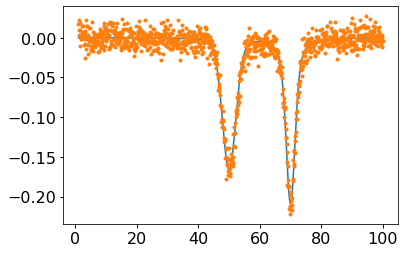

In [ ]:
#redone code from before that works? 
l = np.linspace(1,100,1000)
c = [20, 40]

def f(l, theta):
    Delta = theta[0]
    w = theta[1::2]
    d = theta[2::2]
    return np.sum([-voigt_profile(l-(ci+Delta), wi, di) for ci, wi, di in zip(c, w, d)], axis=0)

np.random.seed(0)

rv = 30
sigma = 0.01
w1 = 2
d1 = 0.5
w2 = 1
d2 = 1
theta = [rv, w1, d1, w2, d2]
dist = norm(f(l, theta), sigma)
D = dist.rvs()

plt.plot(l, f(l,theta), '-')
plt.plot(l, D, '.')
""" 
def loglikelihood(theta):
    sigma = theta[-1]
    return norm(f(l, theta[:-1]), sigma).logpdf(D).sum()
 """
n = 2
nDims = 2*n + 2

wmin = 0
wmax = 10
dmin = 0
dmax = 1
sigma_min = 0
sigma_max = 1
Delta_min = 0
Delta_max = 60

prior_min = np.array([Delta_min] + [wmin, dmin]*n + [sigma_min])
prior_max = np.array([Delta_max] + [wmax, dmax]*n + [sigma_max])

paramnames = [[('Delta', r'\Delta')]] + [[(f'w{i}', f'w_{i}'), (f'd{i}',f'd_{i}')] for i in range(n)] + [[('sigma', r'\sigma')]]
paramnames = [item for sublist in paramnames for item in sublist]

def log_likelihood(theta, l, D):
    sigma = theta[-1]
    residual = D - f(l, theta[:-1])
    return -0.5 * np.sum((residual / sigma)**2 + np.log(2 * np.pi * sigma**2))

# Define the log prior function
def log_prior(theta):
    Delta = theta[0]
    w_values = theta[1::2]
    d_values = theta[2::2]
    if not (Delta_min < Delta < Delta_max):
        return -np.inf
    for w, d in zip(w_values, d_values):
        if not (wmin < w < wmax) or not (dmin < d < dmax):
            return -np.inf
    if not (sigma_min < theta[-1] < sigma_max):
        return -np.inf
    return 0

# Define the log posterior function
def log_probability(theta, l, D):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, l, D)

from pyDOE import lhs
import corner
import tqdm

# Initialize walker positions using Latin hypercube sampling
nwalkers = 15
ndim = 2 * n + 2  # Assuming n is defined elsewhere
bounds = np.array([prior_min, prior_max]).T  # Define bounds for each parameter

lhs_samples = lhs(ndim, samples=nwalkers)
pos = bounds[:, 0] + lhs_samples * (bounds[:, 1] - bounds[:, 0])

#pos = np.array([np.array(theta) + 1 * np.random.randn(len(theta)) for _ in range(nwalkers)])

#nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(l,D))

# Run the sampler
nsteps = 5000
sampler.run_mcmc(pos, nsteps, progress=True)

# Get the samples
samples = sampler.get_chain()#discard=100, thin=15, flat=True)


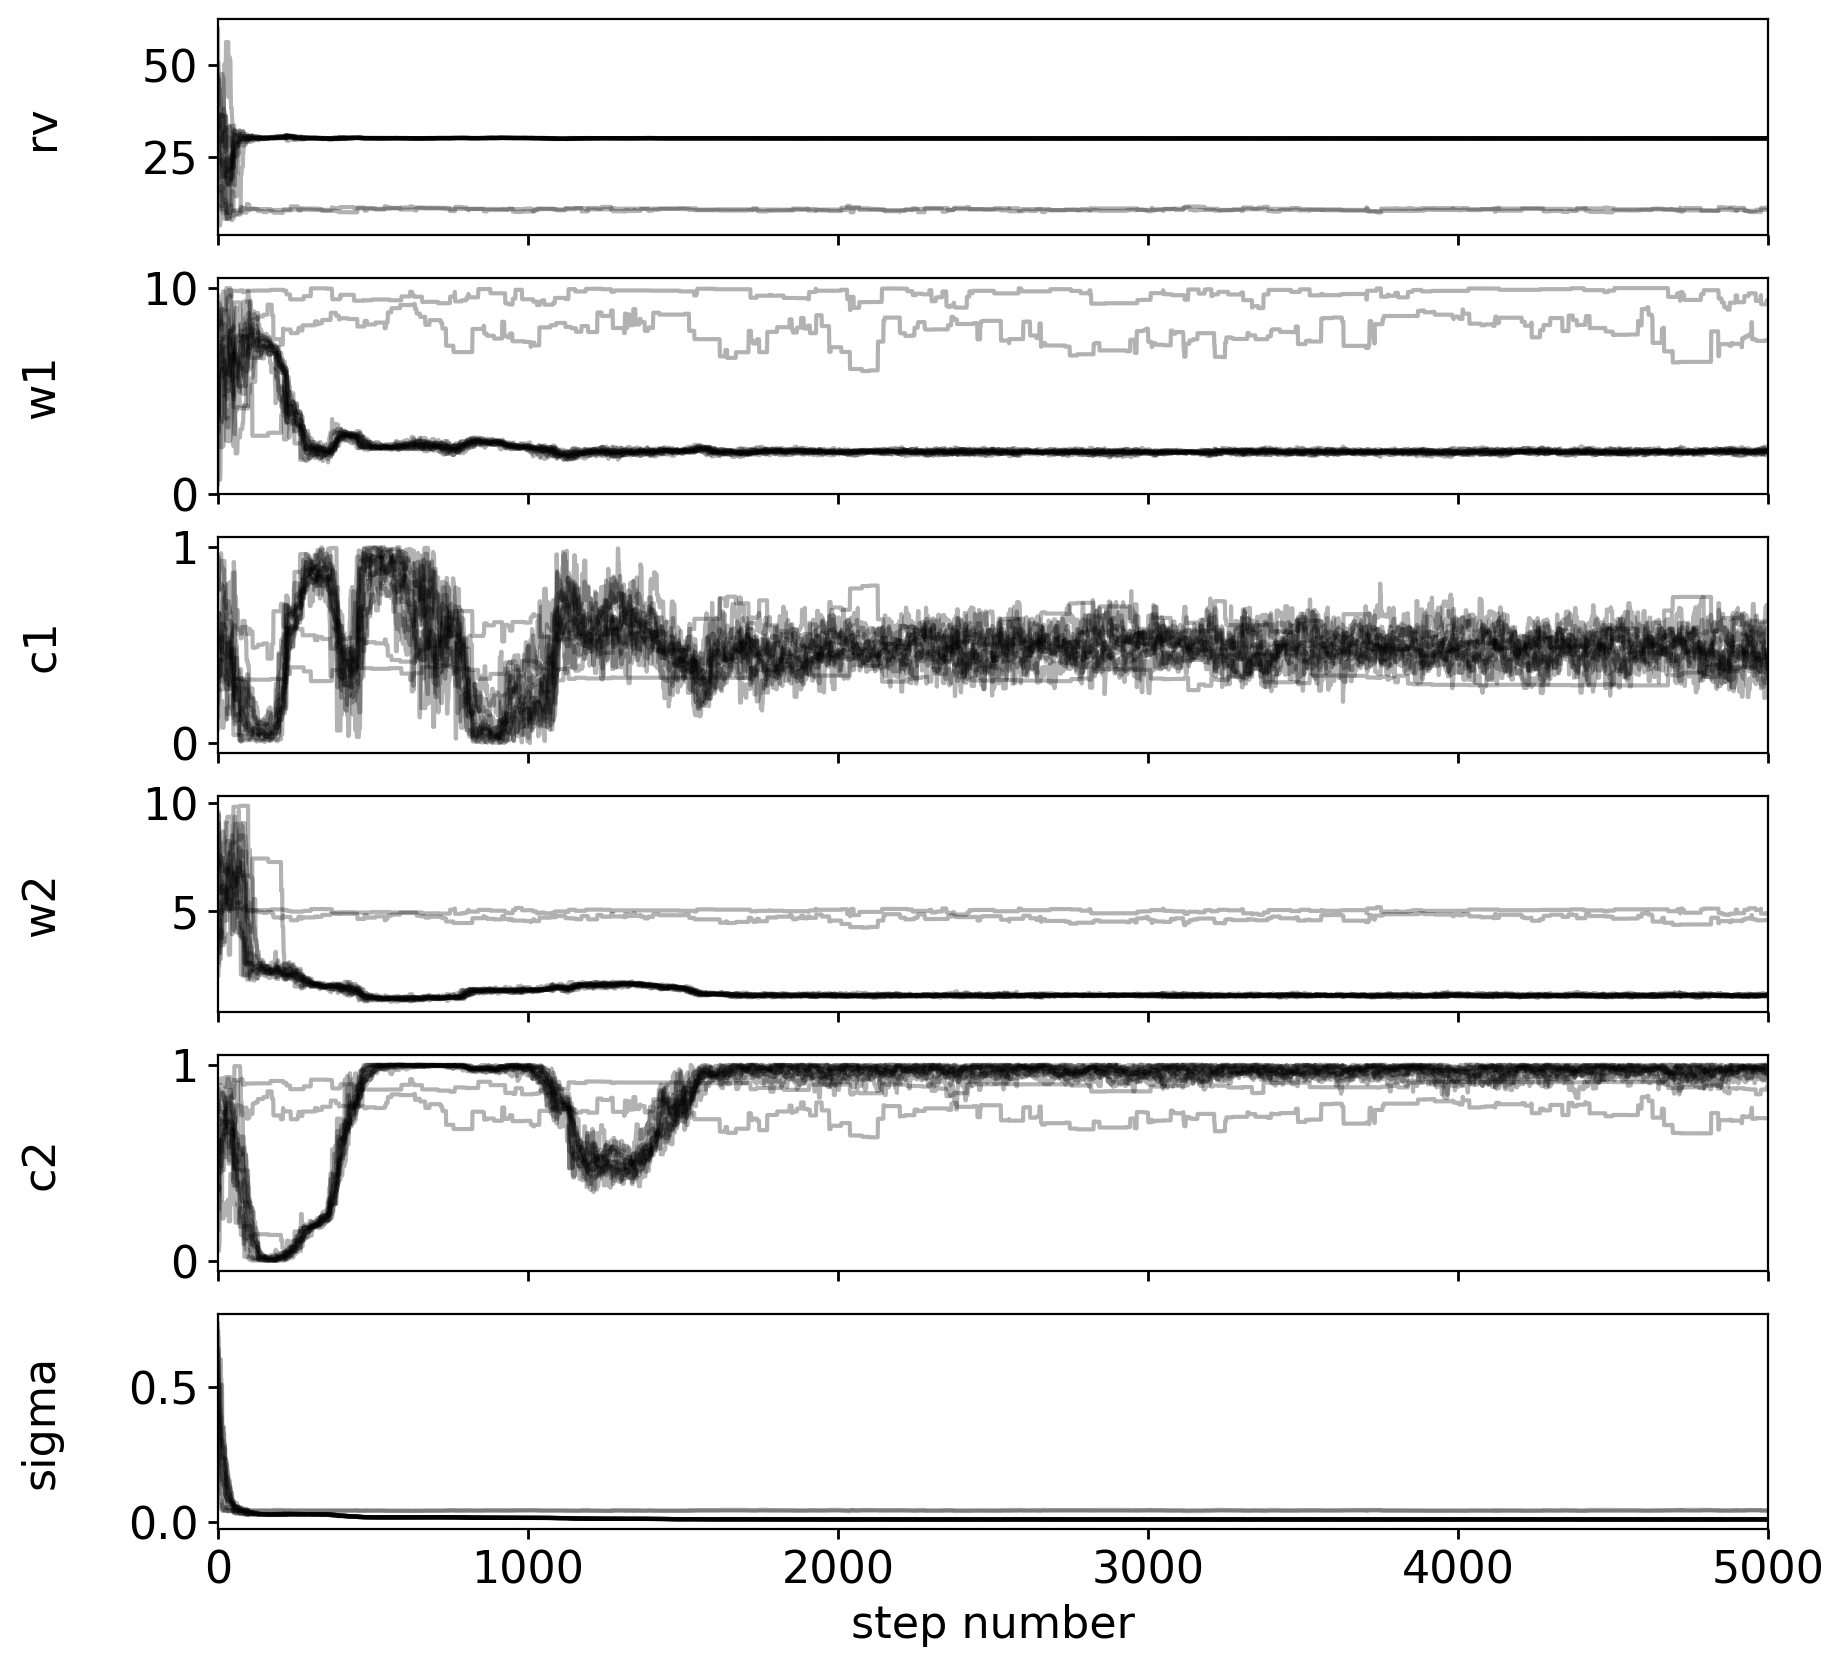

[29.95685224 30.00142905 30.04919654]


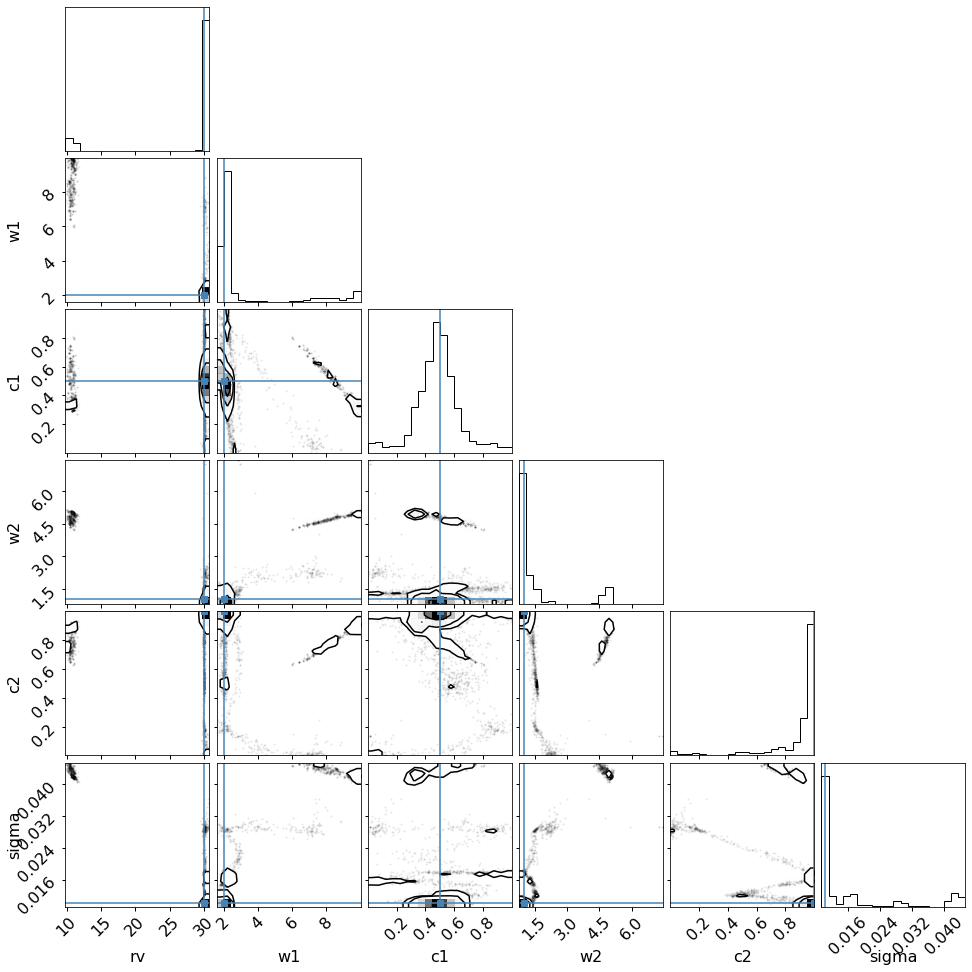

In [ ]:

# Plot the traces
fig, axes = plt.subplots(6, figsize=(10, 10), sharex=True,dpi = 200)
labels = ["rv","w1","c1","w2","c2","sigma"]
for i in range(6):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")
plt.show()

# Flatten the samples
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
percentiles = np.percentile(flat_samples, [16, 50, 84], axis=0)  # This gives the 16th, 50th (median), and 84th percentiles
print(percentiles[:,0])

# Compute the medians of the parameter samples
#rv,w1,c1,w2,c2,sigma = np.median(flat_samples, axis=0)
#print(rv,w1,c1,w2,c2,sigma)


fig = corner.corner(
    flat_samples, labels=labels,truths=[rv, w1, d1, w2, d2,sigma],dpi = 200)

In [ ]:
stop

NameError: name 'stop' is not defined

In [ ]:

#real data


#importing, cropping, and normalising data
wav,flux,t,star = Get_Wavelength_Flux_File("/data/wdplanetary/omri/Data/WD1929+012/2017-1-SCI-031.20170714/product/mbgphH201707140017_u2wm.fits")
#rwav,rflux,t,star = Get_Wavelength_Flux_File("/data/wdplanetary/omri/Data/WD1929+012/2017-1-SCI-031.20170711/product/mbgphR201707110020_u2wm.fits")
#wav = np.concatenate((bwav,rwav))
#flux = np.concatenate((bflux,rflux))
#lower bound of window
u_loc = np.searchsorted(wav, 5200) #5200
closest_value = wav[max(0, u_loc-1)]
u_bound = np.where(wav == closest_value)
u_bound = int(u_bound[0])
#find the lower bound of the window
l_loc = np.searchsorted(wav, 4100) #4100
closest_value = wav[max(0, l_loc-1)]
l_bound = np.where(wav == closest_value)
l_bound = int(l_bound[0])
y = flux[l_bound:u_bound]
l = wav[l_bound:u_bound]
p_result = poly_fit(l,y)
D = y/p_result
sigma = calculate_error(D)/2

#initilizing values
#priors for the values
#gaussian profile for line centre with the x as a function
c_vals = []
c_priors_list = []
lines = ([i[1] for i in b_lines])
c1 = np.array(lines)
""" 
for j in c1:
    gaussian = (norm.pdf(D, j, 0.04)) #make a prior function for the line 
    plt.plot(D,gaussian)
    plt.show()
    sum = np.sum(gaussian)
    c_priors_list.append(sum)
 """

n = len(c1)
print(f"number of lines: {n}")
#initial values
rv = 36
#sigma = 0.03
s1 = np.full((n,), 0.3)
g1 = np.full((n,), 0.3)
d1 = np.full((n,), 0.6)
offset = np.full((n,), 0)


arrays_theta = [rv, s1, g1, d1, c1,offset]  # Assuming theta is a list containing both scalar values and arrays/lists
theta = []  # Initialize an empty list to store the expanded values
# Iterate through each element in theta
for item in arrays_theta:
    # Check if the current item is an array/list
    if isinstance(item, (list, np.ndarray)):
        # If it is an array/list, extend the expanded_theta list with its elements
        theta.extend(item)
    else:
        # If it's a scalar value, append it directly to the expanded_theta list
        theta.append(item)
print("---------")
print(f"the starting values are{theta}")
print("---------")
#limits on the priors
cmin = c1 - 0.2
cmax = c1 + 0.2
print(f"The lines we are using, and their minimum/maximum wavelengths are: {c1}")
print(f"{cmin}")
print(f"{cmax}")
smin = 0 #sigma of the fit
smax = 1
gmin = 0 #gamma of the fit
gmax = 1
dmin = 0 #depth of the fit
dmax = 2
offset_min = -1 #offset of the fit
offset_max = 1
Delta_min = 0 #RV shift
Delta_max = 60



def f(l, theta):
    #function to generate the model
    Delta = float(theta[0])
    s = theta[1::n]
    g = theta[2::n]
    d = theta[3::n]
    c = theta[4::n]
    offset_values = theta[5::n] 
    return 1 + np.sum([ offset + (-voigt_profile((l-(ci*(1+Delta/299792.0))),si, gi )*di) for ci, si,gi, di,offset in zip(c, s,g, d,offset_values)], axis=0)
    
for i in lines:
    plt.plot(l, f(l,theta))
    plt.plot(l,D)
    plt.fill_between(l,f(l,theta) - sigma, f(l,theta) + sigma, color='gray', alpha=0.3)
    plt.xlim(i -10,i +10 )
    plt.ylim(0.4,1.6)
    plt.show()
    

prior_mini = np.array([Delta_min] + [smin,gmin, dmin, offset_min]*n ) 
prior_min = np.concatenate((prior_mini,cmin))

prior_maxi = np.array([Delta_max] + [smax,gmax, dmax, offset_max ]*n )
prior_max = np.concatenate((prior_maxi,cmax))


def log_likelihood(theta, l, D,sigma):
    residual = D - f(l, theta[:-1])
    return -0.5 * np.sum((residual / sigma)**2 + np.log(2 * np.pi * sigma**2))

# Define the log prior function
def log_prior(theta):
    total_log_prior = 0
    #defining priors again
    Delta = theta[0]
    s_values = theta[1::n]
    g_values = theta[2::n]
    d_values = theta[3::n]
    c_values = theta[4::n]
    offset_values = theta[5::n] 

    #setting the logprior to False if outside the priors
    if not (Delta_min < Delta < Delta_max):
        return -np.inf
    if not (Delta_min < Delta < Delta_max):
        return -np.inf

    for (s,g, d,c,offs,c_init) in (zip(s_values, g_values, d_values,c_values,offset_values, c1)):
        c_prior_logpdf = np.sum(norm.logpdf(c, loc = c_init,scale = 0.04))
        total_log_prior += c_prior_logpdf

        offset_prior_logpdf = np.sum(norm.logpdf(offset, loc = 0,scale = 0.2))
        total_log_prior += offset_prior_logpdf

        if not (smin < s < smax) or not (gmin < g < gmax) or not (dmin < d < dmax) or not (c_init -0.5 < c < c_init+0.5) or not (offset_min < offs < offset_max):
            return -np.inf
    #adding a logprior function
    
    #prior_mu = norm.logpdf(theta[0], loc=0, scale=1)
    
    return total_log_prior

# Define the log posterior function
def log_probability(theta, l, D, sigma):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, l, D, sigma)



# Initialize walker positions using Latin hypercube sampling
""" 
from pyDOE import lhs
nwalkers = 64
ndim = len(theta)  # Assuming n is defined elsewhere
bounds = np.array([prior_min, prior_max]).T  # Define bounds for each parameter
lhs_samples = lhs(ndim, samples=nwalkers)
data = pd.DataFrame(lhs_samples)
pos = bounds[:, 0] + lhs_samples * (bounds[:, 1] - bounds[:, 0])
 """

 
#initialise walkers and pos using normal gaussian distributions
pos = (theta) + 1e-4 * np.random.randn(3*len(theta), len(theta))
nwalkers, ndim = pos.shape 



# Run the sampler
nsteps = 2000
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(l,D,sigma))
sampler.run_mcmc(pos, nsteps, progress=True)




In [ ]:
#with plt.rc_context(default_settings):
plt.rcParams.update(default_settings)
paramnames = [[('RV', r'\Delta')]] + [[(f's{i}', f's_{i}'), (f'g{i}', f'g_{i}'),(f'd{i}',f'd_{i}'),(f'c{i}',f'c_{i}'),(f'offset{i}',f'offset_{i}')] for i in range(n)] 
paramnames = [item for sublist in paramnames for item in sublist]

# Get the samples
samples = sampler.get_chain(discard=100, thin=1, flat=False)
labels = [name_tuple[0] for name_tuple in paramnames]
# Plot the traces

#plotting all the variables

fig, axes = plt.subplots(len(labels), figsize=(10, 10), sharex=True)
#labels = ["rv","w1","d1","w2","d2","sigma"]
for i in range(len(labels)):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")
plt.show() 
""" 
fig, axes = plt.subplots(1, figsize=(10, 6), sharex=True)
axes.plot(samples[:, :, 0], "k", alpha=0.3)
axes.set_xlim(0, len(samples))
axes.set_ylabel("RV (km/s)")
axes.yaxis.set_label_coords(-0.1, 0.5)
axes.set_xlabel("step number")
plt.show() """

# Flatten the samples
flat_samples = sampler.get_chain(discard=0, thin=15, flat=True)
percentiles = np.percentile(flat_samples, [16, 50, 84], axis=0)  # This gives the 16th, 50th (median), and 84th percentiles


print(percentiles)
# Compute the medians of the parameter samples
#variables = percentiles[1]
variables = np.median(flat_samples, axis=0)
#print(rv,w1,c1,w2,c2,sigma)
#print(variables[1:3])
print(variables)

""" 
print(f"wav = {l}, model ={f(l,variables)}")

plt.figure()
plt.plot(l, f(l,variables),color = "red")
plt.plot(l,D,color = "black")
plt.fill_between(l, (D - sigma), (D + sigma), color='gray', alpha=0.3)                   
plt.xlim(4481 -10,4481 +10 )
plt.ylim(0.4,1.6)
plt.show()
"""


fig = corner.corner(
    flat_samples, labels=labels,truths=[variables])
""" 
variables = {
    "rv": rv,
    "w1": w1,
    "c1": c1,
    "w2": w2,
    "c2": c2,
    "sigma": sigma} 
# Annotate variables on the plot
for i, (var_name, var_value) in enumerate(variables.items()):
    plt.annotate(f"{var_name}: {var_value:.5f}", xy=(-1, 5.5 - i * 0.5), xycoords='axes fraction', fontsize=20, ha='left')
"""
# Annotate variables on the plot
for i, var_value in enumerate(variables.items()):
    plt.annotate(f" {var_value:.5f}", xy=(-1, 4.5 - i * 0.5), xycoords='axes fraction', fontsize=20, ha='left')

#save data
time = t.datetime
#save the datafiles instead of stacking the plot here
data = pd.DataFrame({"labels": labels, "flat samples": flat_samples, "truths": variables,"percentiles": percentiles, "wavelength": l, "model flux":(f(l,variables)),"flux": (D),"time": time}) #[t],[snr], [depth], [rv], [err]])
dir_name = f"/data/wdplanetary/omri/Output/resultfiles/WD1929/MCMC_Bayesian/bluespectrum/"
dir_name_without_spaces = dir_name.replace(" ", "")
os.makedirs(dir_name_without_spaces, exist_ok=True)
file_end = f"{time}_test.txt"
file_name = os.path.join(dir_name_without_spaces, file_end)
file_name_without_spaces = file_name.replace(" ", "")
#np.savetxt(file_name_without_spaces, data, delimiter=',', fmt = '%f') #"fmt=['%f', '%f', '%f', '%s', '%f', '%f', '%f', '%f'])
data.to_csv(file_name_without_spaces, sep='\t', index=False)
#how to read the data back in 
#data = pd.read_csv("/data/wdplanetary/omri/Output/resultfiles/WD1929/Voigt_fitting/only_mg_line/snr_cutoff_16.05612842459828/2021-04-21T03:09:52.703/4481.185.txt", sep='\t')




fig = corner.corner(
    flat_samples, labels=labels, truths=[m_true, b_true, np.log(f_true)]
);

In [ ]:

#CrossCorrRV run file for the self-correlation
window_size = 100.
wav_reference,flux_reference,ref_time,ref_object = Get_Wavelength_Flux_File(
    '/data/wdplanetary/omri/Data/WD1929+012/2017-1-SCI-031.20170730/product/mbgphH201707300036_u2wm.fits')

#could also use this as the best: /data/wdplanetary/omri/Data/WD1929+012/2017-1-SCI-031.20170730/product/mbgphH201707300036_u2wm.fits
btime_strings = [(ref_time)]
bvels = [(0)]
brverrs = [(0)]
snr_cutoff = 8

for i in b_files:
    wav_observed,flux_observed,obs_time,obs_object = Get_Wavelength_Flux_File(i)
    if obs_object.startswith(str(ref_object)):
        snr = np.median(flux_observed)/(np.std(flux_observed))
        #print(snr)
        rv_max,sigma = RVCC(wav_reference,flux_reference,wav_observed,flux_observed,window_size)
        #bvels.append((rv[np.argmax(cc)]))
        #rv_max,sigma = CCF_processing_gaussian(rv,cc)
        #popt,pcov = CCF_processing(rv,cc)
        #print(popt,pcov)
        bvels.append(rv_max)
        btime_strings.append(obs_time)
        brverrs.append(sigma)
    else:
        print("This is a file for" + str(obs_object))
        continue


The reference pixel in timefile: 2017-07-30T20:01:57.953 is 1.0


NameError: name 'b_files' is not defined

In [ ]:
#code to manually check data at the end of each run
#code to manually check data at the end of each run
print(np.mean(bvels),np.std(bvels))

#print(bvels_from_argmax)
#print(brverrs)
#print(btime_strings)
t_list = Time(btime_strings, scale='utc')
times = t_list.datetime 
t0 = times[0]
tdays = [(dt - t0).days for dt in times]
thours = [(dt - t0).seconds // 3600 for dt in times]
tminutes = [(dt - t0).seconds % 3600 // 60 for dt in times]
times_list = tdays + thours +tminutes
print(times_list)
averages = np.array([tdays,bvels,brverrs])
print(averages)
np.savetxt("/data/wdplanetary/omri/Output/resultfiles/SelfCCF/blue_spec_salt.txt",averages)

In [ ]:
#plotting for the cross_correlation
t_list = Time(btime_strings, scale='utc')
times = t_list.datetime 
t0 = times[0]
tdays = [(dt - t0).days for dt in times]
tarray = np.array(tdays)
rvarray = np.array(bvels)
rverrsarray = np.array(brverrs)

#rverrsarray = np.full(len(tarray),2)

""" filtered_indices = np.where((rverrsarray < 100) & (rvarray > 0))[0] #& (rvarray > 10)
filtered_rvarray = rvarray[filtered_indices]
filtered_tarray = tarray[filtered_indices]
filtered_rverrsarray = rverrsarray[filtered_indices]
filtered_rvcorrsarray = rvcorrsarray[filtered_indices] """

bvels= bvels[:len(btime_strings)]

unique_times = np.unique(tarray)

averages = np.array([[t, np.nanmean(rvarray[tarray == t]), np.nanmean(rverrsarray[tarray == t])] for t in unique_times])
#averages = averages[np.isnan(averages[:,1])]

#print(averages)
file_name = "/data/wdplanetary/omri/Output/resultfiles/crosscorrRV_bluespec_results.txt"
np.savetxt(file_name, averages, delimiter=',', fmt='%f')

In [ ]:
#Radial Velocity variations with time plot
file_name = "/data/wdplanetary/omri/Output/resultfiles/crosscorrRV_bluespec_results.txt"
averages = np.loadtxt(file_name, delimiter=',')
t = averages[:, 0]
v = averages[:, 1] 
mean = np.mean(v)
#errs = np.full(len(v),0.5)
errs = averages[:, 2] 
stdev = np.std(v)



plt.figure(facecolor='white',figsize = (14,8),dpi = 300)
plt.errorbar(t, v, yerr=errs,fmt = '.k',lw = 0.5)
plt.fill_between(t, -stdev, stdev, color='gray',label = "1 sigma", alpha=0.4)
plt.fill_between(t, -3* stdev, 3* stdev, color='gray',label = "3 sigma", alpha=0.2)
plt.legend()
legend_pos = plt.gca().get_legend().get_texts()[0].get_position()
#plt.text(1000, 12 , f"RV mean = {mean:.3g}")
plt.text(1000, 12 - 2, f'Sigma = {stdev:.3g}')


plt.xlabel("Time - Days")
plt.ylabel("Change in Radial Velocity - km/s")
#plt.title("WD1929+012 Radial Velocity variations using Voigt fits - SALT data")
plt.text
plt.gcf().autofmt_xdate()
#plt.xticks(rotation=45)
#plt.tight_layout()
#plt.ylim(-20,20)
#plt.xlim(0,112)
#plt.savefig("/data/wdplanetary/omri/Output/DeltaRV_CrossCorr_bluespec.pdf")
plt.show()


frequencies = np.linspace(0.001,40,1000)
#frequencies = np.linspace(1/1000, 50, num=400000)

power = LombScargle(t, v,errs).power(frequencies)

plt.plot(frequencies, power/np.max(power))
plt.title("Periodogram of the radial velocity measurements of WD1929+012")
plt.ylabel("Power")
plt.xlabel("Frequency")
plt.figure(facecolor='white')
plt.show()





In [ ]:
#Runfile for the cross-correlation with the model spectrum
star = "WD1929+012"

#import the Koester model
data_path = "/home/omn24/Documents/Code/koester2/da21000_800.dk.dat.txt"
wavelengths = []
fluxes = []

with open(data_path, 'r') as file:
    lines = file.readlines()

for line in lines[6:]:
  # Split the line into columns (assuming whitespace as delimiter)
    columns = line.split()
    
    # Convert wavelength and flux to float and append to respective lists
    wavelengths.append(columns[0])
    fluxes.append(columns[1])

# Convert lists to NumPy arrays
m_wav = np.array(wavelengths).astype(float)
m_flux = np.array(fluxes).astype(float)
model_wav,model_flux = process_data_model(m_wav,m_flux,b_lines)


window_size = 100.
btime_strings = []
bvels = []
bvels_from_argmax = []
brverrs = []
snr_cutoff = 10

#running part
for i in b_files:
    wav_observed,flux_observed,obs_time,obs_object = Get_Wavelength_Flux_File(i)
    
    
    if obs_object.startswith(star):
        #snr = np.median(flux_observed)/(np.std(flux_observed))
        #print(snr)
        
        rv_max,sigma,rv_max_from_argmax = RVCC_model(model_wav, model_flux,wav_observed,flux_observed,window_size,b_lines,obs_time)
        #bvels.append((rv[np.argmax(cc)]))
        #rv_max,sigma = CCF_processing_gaussian(rv,cc)
        #popt,pcov = CCF_processing(rv,cc)
        #print(popt,pcov)
        bvels.append(rv_max)
        btime_strings.append(obs_time)
        brverrs.append(sigma)
        bvels_from_argmax.append(rv_max_from_argmax)
    else:
        print("This is a file for" + str(obs_object))
        continue



In [ ]:
#code to manually check data at the end of each run
print(np.mean(bvels),np.std(bvels))
print(np.mean(bvels_from_argmax), np.std(bvels_from_argmax))
#print(bvels_from_argmax)
#print(brverrs)
#print(btime_strings)
t_list = Time(btime_strings, scale='utc')
time_format = "%Y-%m-%d %H:%M"
# Convert each Time object to the desired format
time_strings = [time.strftime(time_format) for time in t_list]

times = t_list.datetime 
t0 = times[0]
tdays = [(dt - t0).days for dt in times]
thours = [(dt - t0).seconds // 3600 for dt in times]
tminutes = [(dt - t0).seconds % 3600 // 60 for dt in times]
times_list = tdays + thours +tminutes
print(time_strings)
averages = np.array([time_strings,bvels,bvels_from_argmax,brverrs])
print(averages)
np.savetxt("/data/wdplanetary/omri/Output/resultfiles/ModelCCF/blue_spec_abs_lines_t_datetime.txt",averages)

40.02338122627301 4.50385120616466
37.916981132069616 2.0440189646736187
['2017-07-06 21:34', '2017-07-06 21:50', '2017-07-06 22:06', '2017-07-11 23:29', '2017-07-11 23:45', '2017-07-12 00:01', '2017-07-14 21:22', '2017-07-14 21:38', '2017-07-14 21:54', '2017-07-22 20:21', '2017-07-22 20:37', '2017-07-22 20:53', '2017-07-30 19:45', '2017-07-30 20:01', '2017-07-30 20:18', '2017-08-02 21:57', '2017-08-02 22:13', '2017-08-09 19:28', '2017-08-09 19:44', '2017-08-09 20:00', '2017-08-13 19:11', '2017-08-13 19:27', '2017-08-13 19:43', '2017-08-23 18:26', '2017-08-23 18:42', '2017-08-23 18:58', '2017-09-26 18:55', '2017-09-26 19:13', '2018-06-11 23:20', '2018-06-11 23:26', '2018-06-11 23:33', '2019-08-20 21:12', '2019-08-20 21:37', '2020-05-16 01:14', '2020-05-16 01:35', '2020-05-25 01:53', '2020-05-25 02:14', '2020-05-31 23:45', '2020-06-01 00:06', '2020-06-20 23:18', '2020-07-19 22:07', '2020-07-24 21:44', '2020-07-27 21:14', '2020-07-27 21:36', '2020-07-30 22:27', '2021-04-13 02:55', '2021-

TypeError: Mismatch between array dtype ('<U22') and format specifier ('%.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e')

In [ ]:
#plotting for the model_ cross_correlation
t_list = Time(btime_strings, scale='utc')
times = t_list.datetime 
t0 = times[0]
tdays = [(dt - t0).days for dt in times]
tarray = np.array(tdays)
rvarray = np.array(bvels)
rverrsarray = np.array(brverrs)

#rverrsarray = np.full(len(tarray),2)

""" filtered_indices = np.where((rverrsarray < 100) & (rvarray > 0))[0] #& (rvarray > 10)
filtered_rvarray = rvarray[filtered_indices]
filtered_tarray = tarray[filtered_indices]
filtered_rverrsarray = rverrsarray[filtered_indices]
filtered_rvcorrsarray = rvcorrsarray[filtered_indices] """

bvels= bvels[:len(btime_strings)]

unique_times = np.unique(tarray)

averages = np.array([[t, np.nanmean(rvarray[tarray == t]), np.nanmean(rverrsarray[tarray == t])] for t in unique_times])
#averages = averages[np.isnan(averages[:,1])]

#print(averages)
file_name = "/data/wdplanetary/omri/Output/resultfiles/crosscorrRV_model_mg4481_bothlines_results.txt"
np.savetxt(file_name, averages, delimiter=',', fmt='%f')

In [ ]:
#Radial Velocity variations with time plot

t = averages[:, 0]
v = averages[:, 1] 
mean = np.mean(v)
v = v- np.mean(v)
#errs = np.full(len(v),0.2)
errs = averages[:, 2] + 0.2
stdev = np.std(v)

""" fig, (ax_t, ax_w) = plt.subplots(2, 1,figsize = (10,6), constrained_layout=True)
ax_t.errorbar(t, y, yerr=dy, fmt='b+', label='Data with Errors')
ax_t.set_xlabel('Time [days]')
ax_t.legend()

ax_w.plot(frequency, power)
ax_w.set_xlabel('Angular frequency [rad/days]')
ax_w.set_ylabel('Normalized amplitude')
plt.show() """

plt.figure(facecolor='white',figsize = (10,6))
plt.errorbar(t, v, yerr=errs,fmt = '.k',lw = 0.4)
plt.fill_between(t, -stdev, stdev, color='gray',label = "1 sigma", alpha=0.4)
plt.fill_between(t, -3* stdev, 3* stdev, color='gray',label = "3 sigma", alpha=0.2)
plt.legend()
legend_pos = plt.gca().get_legend().get_texts()[0].get_position()
plt.text(1200, 3, f"RV mean = {mean:.3g}")
plt.text(1200, 2.5, f'sigma = {stdev:.3g}')


plt.xlabel("Time - Days")
plt.ylabel("Change in Radial Velocity - km/s")
#plt.title("WD1929+012 Radial Velocity variations using Voigt fits - SALT data")
plt.text
plt.gcf().autofmt_xdate()
#plt.xticks(rotation=45)
#plt.tight_layout()
#plt.ylim(-20,20)
#plt.xlim(0,112)
plt.savefig("/data/wdplanetary/omri/Output/DeltaRV_CrossCorr_model_4481_bothlines.pdf")
plt.show()

In [ ]:
#Runfile for the Cross-correlation code

#for the blue files
btime_strings = []
bvels = []
brverrs = []
bwav_reference,bflux_reference,ref_time,ref_object = Get_Wavelength_Flux_File(
    "/data/wdplanetary/omri/Data/WD1929+012/2017-1-SCI-031.20170706/product/mbgphH201707060019_u2wm.fits")
#bwav_reference,bflux_reference = process_data_cc(bwav_reference,bflux_reference)

rwav_reference,rflux_reference,ref_time,ref_object = Get_Wavelength_Flux_File(
    "/data/wdplanetary/omri/Data/WD1929+012/2017-1-SCI-031.20170706/product/mbgphR201707060019_u2wm.fits")
#rwav_reference,rflux_reference = process_data_cc(rwav_reference,rflux_reference)


#rwbox,rfbox = splitfiles(bwav_reference,bflux_reference)
btime_strings.append((ref_time))
bvels.append(0)
brverrs.append(0)
w_size = 20

for i,j in zip(b_files,r_files):
    
    v = []
    wavelength_observed, flux_observed,time,obs_object = Get_Wavelength_Flux_File(i)
    
    if obs_object.startswith(star):

        wavelength_observed, flux_observed = process_data_cc(wavelength_observed, flux_observed)
        
        # Perform cross-correlation for boxes
        #owbox,ofbox = splitfiles(wavelength_observed, flux_observed)
        #for i in rfbox:
        #    print(len(i))
        #for i in ofbox:
        #    print(len(i))
        #for (ofbox, rfbox) in enumerate(zip(ofbox, rfbox)):
        #    rv = cross_correlation(rfbox, ofbox)
        #    v.append(rv)
        #vel = np.mean(v)
        #err = np.std(v)
    
        #Perform cross-correlation for each line and the boxes around it:
        
        for line in b_lines:
            r_wav, r_flux = split_files_by_line(bwav_reference,bflux_reference,line[1],w_size)
            o_wav, o_flux = split_files_by_line(wavelength_observed,flux_observed,line[1],w_size)
            vel,err = cross_correlation(r_flux,o_flux,o_wav,time)
            print(vel,err)
            
            s_wav = [val * (1 + vel / 299792) for val in o_wav]
            plt.plot(s_wav,o_flux,  color = 'blue',linewidth =0.5,label = ("Shifted Spectrum" + str(time.datetime)))
            plt.plot(r_wav,r_flux, color = 'green',linewidth =0.5,label = "Reference Spectrum")
            #plt.xlim(4470,4494)
            #plt.ylim(0,0.02)
            plt.legend()
            plt.show()
            print(vel)
        
            btime_strings.append(time)
            bvels.append(vel)
            brverrs.append(err)
    else:
        print("This is a file for " + str(obs_object) + " instead of " + str(star))
        continue
        
    
    wavelength_observed, flux_observed,time,obs_object = Get_Wavelength_Flux_File(j)

    if obs_object.startswith(star):   
        wavelength_observed, flux_observed = process_data_cc(wavelength_observed, flux_observed)

        for line in r_lines:
            r_wav, r_flux = split_files_by_line(rwav_reference,rflux_reference,line[1],w_size)
            o_wav, o_flux = split_files_by_line(wavelength_observed,flux_observed,line[1],w_size)
            vel,err = cross_correlation(r_flux,o_flux,o_wav,time)
            print(vel,err)
            
            s_wav = [val * (1 + vel / 299792) for val in o_wav]
            plt.plot(s_wav,o_flux,  color = 'blue',linewidth =0.5,label = ("Shifted Spectrum" + str(time.datetime)))
            plt.plot(r_wav,r_flux, color = 'green',linewidth =0.5,label = "Reference Spectrum")
            #plt.xlim(4470,4494)
            #plt.ylim(0,0.02)
            plt.legend()
            plt.show()
            print(vel)
        
            btime_strings.append(time)
            bvels.append(vel)
            brverrs.append(err)
        

        #vel,err = cross_correlation(rflux_reference,flux_observed,wavelength_observed,time)
        #btime_strings.append(time)
        #bvels.append(vel)
        #brverrs.append(err)
    else:
        print("This is a file for " + str(obs_object) + " instead of " + str(star))
        continue
        

print(np.mean(bvels))
print(np.std(bvels))
    #do the plotting of the shifted spectra here:
    




#Runfile for the PyAstronomy CrosscorrRV code

#for the blue files
btime_strings = []
bvels = []
#"/home/omn24/Documents/Documents/product/mbgphH201707060019_u2wm.fits"
wav_reference,flux_reference,ref_time = Get_Wavelength_Flux_File("/data/wdplanetary/omri/Data/WD1929+012/2017-1-SCI-031.20170706/product/mbgphH201707060019_u2wm.fits")
btime_strings.append((ref_time))
bvels.append(0)
for i in b_files:
    wavelength_observed, flux_observed,time = Get_Wavelength_Flux_File(i)
    # Perform cross-correlation
    vel = crosscorrRV(wav_reference,flux_reference,wavelength_observed, flux_observed)
    btime_strings.append(time)
    bvels.append(vel)



#for the red files
rtime_strings = []
rvels = []
wav_reference,flux_reference,ref_time = Get_Wavelength_Flux_File("/data/wdplanetary/omri/Data/WD1929+012/2017-1-SCI-031.20170706/product/mbgphR201707060019_u2wm.fits")
rtime_strings.append((ref_time))
rvels.append(0)
for i in r_files:
    wavelength_observed, flux_observed,time = Get_Wavelength_Flux_File(i)
    # Perform cross-correlation
    vel = crosscorrRV(wav_reference,flux_reference,wavelength_observed, flux_observed)
    rtime_strings.append(time)
    rvels.append(vel)




In [ ]:
#Plots for Cross Correlation
#Combining data points that are the same times
t_list = Time(btime_strings, scale='utc')
times = t_list.datetime
tarray = np.array(times)
rvarray = np.array(bvels)
rverrsarray = np.array(brverrs)
#rverrsarray = np.full(len(tarray),2)

unique_times = np.unique(tarray)
averages = np.array([[t, np.mean(rvarray[tarray == t]), np.mean(rverrsarray[tarray == t])] for t in unique_times])
#print(averages)
file_name = "/data/wdplanetary/omri/Output/resultfiles/cross_correlation.txt"
np.savetxt(file_name, averages, delimiter=',', fmt='%f')

#d = pd.DataFrame(data=[tarray, rvarray, rverrsarray], columns=["Time", "RV", "Errors"])

t = averages[:, 0]
v = averages[:, 1] - np.nanmean(averages[:, 1])
#errs = np.full(len(v),0.5)
errs = averages[:, 2]
t0 = t[0]
tdays = [(dt - t0).days for dt in t]
stdev = np.std(v)

plt.figure(facecolor='white')
plt.errorbar(tdays, v, yerr=errs,fmt = '.k')
plt.fill_between(tdays, -stdev, stdev, color='gray',label = "1 sigma", alpha=0.4)
plt.fill_between(tdays, -3* stdev, 3* stdev, color='gray',label = "3 sigma", alpha=0.2)
plt.legend()
plt.xlabel("Time - Days")
plt.ylabel("Change in Radial Velocity - km/s")
plt.title("WD1929+012 Radial Velocity variations using \n Cross-Correlation Functions - SALT data")
plt.gcf().autofmt_xdate()
#plt.xticks(rotation=45)
#plt.tight_layout()
#plt.ylim(30,50)
#plt.xlim(0,112)
plt.savefig("/data/wdplanetary/omri/Output/DeltaRVGaussian.pdf")
plt.show()


In [ ]:
#CCF self-correlation for MIKE
rvs = []
time_strings = []
rverrs = []

n = 0
mike_blue_plot_dir =  "/data/wdplanetary/omri/Output/mike/referenceCCF/"
stacked_plot_dir =  "/data/wdplanetary/omri/Output/stackedplots/"

ref_order,ref_wav,ref_flux,ref_snr,refOBJECT,ref_time = read_mike_spec("/data/wdplanetary/laura/MIKE/Data/WD1929+011/blue/galex1931_blue_2010-06-17.fits")
rvs.append(0)
time_strings.append(ref_time)
rverrs.append(0)

star = "G"

#fig, ax = plt.subplots(figsize=(6, 20))

for j in mike_b_files:
    order,wav,flux,snr,obs_OBJECT,obs_time =read_mike_spec(j)
    
    xwav_list = np.empty(len(order), dtype=object)
    padded_flux_list = np.empty(len(order), dtype=object)
    moving_avg_list = np.empty(len(order), dtype=object)
    errors_list = np.empty(len(order), dtype=object)
    snr_list = np.empty(len(order), dtype=object)

    print("imported files")
    if obs_OBJECT.startswith(star):
        #then call data processing
        for o in order:
            #xwav,padded_flux,moving_avg = process_data_mike_gaussian(wav[o-1],flux[o-1],b_lines)
            obs_wav, obs_flux = wav[o-1],flux[o-1]
            r_wav,r_flux = ref_wav[o-1],ref_flux[o-1] 

            for i in b_lines:
                line = float(i[1])
                if np.min(obs_wav) <= line <= np.max(obs_wav):
                    
                    rv,err = RVCC_MIKE(r_wav,r_flux,obs_wav,obs_flux,line,obs_time)
                    rvs.append(rv)
                    time_strings.append(obs_time)
                    rverrs.append(err)
                    print("The fit has been calculated successfully")
            
    else:
        print("This is a file for " + str(obs_OBJECT) + " instead of " + str(star))
        continue

     

In [ ]:
#Voigt fitting runfile for MIKE
rvs = []
time_strings = []
rverrs = []

n = 0
mike_blue_plot_dir =  "/data/wdplanetary/omri/Output/mike/Gaussianline/blue/"
stacked_plot_dir =  "/data/wdplanetary/omri/Output/stackedplots/"

star = "G"

stacked_plot_dir =  "/data/wdplanetary/omri/Output/stackedplots/"
#fig, ax = plt.subplots(figsize=(6, 20))

for files_list in (mike_r_files,mike_b_files):
    for j in files_list:
        order,wav,flux,snr,OBJECT,time =read_mike_spec(j)
        
        xwav_list = np.empty(len(order), dtype=object)
        padded_flux_list = np.empty(len(order), dtype=object)
        moving_avg_list = np.empty(len(order), dtype=object)
        errors_list = np.empty(len(order), dtype=object)
        snr_list = np.empty(len(order), dtype=object)

        print("imported files")
        if OBJECT.startswith(star):
            #then call data processing
            for o in order:
                xwav,padded_flux,moving_avg = process_data_mike_gaussian(wav[o-1],flux[o-1],r_lines)
                errors = calculate_error(padded_flux)  

                xwav_list[o-1] = xwav
                padded_flux_list[o-1] = padded_flux
                moving_avg_list[o-1] = moving_avg
                errors_list[o-1] = errors
                snr_list[o-1] = snr[o-1]
            
            #print(xwav_list)
            #print(snr)

            print("Smoothed flux and calculated errors") 
            #print(errors,padded_flux,moving_avg)      
            #then do Gaussian
            rv,rv_err,n = Mike_Gaussian(xwav_list,padded_flux_list,moving_avg_list,errors_list,snr_list,r_lines,time,n,mike_blue_plot_dir)
            #now need to add to directories of wavelengths, flux_results, best_fits,snrs, line depths
            
            #Then find the atmospheric correction- don't need to do this as we have the stabilities
            #rv_corr,corr_err,ax = Gaussian(xskywav,sky_padded_flux,sky_moving_avg,sky_errors,sky_lines,skytime,n,ax)
            if np.isnan(rv) : #or np.isnan(rv_corr):
                print("Fit could not be calculated")
                continue

            else:
                #rv_corrs.append((rv_corr))
                rvs.append((rv)) #-rv_corr
                rverrs.append((rv_err )) 
                time_strings.append((time))
                print("The fit has been calculated successfully")
        else:
            print("This is a file for " + str(OBJECT) + " instead of " + str(star))
            continue

""" 
#Now show the stacked plot
ax.set_xlabel('Wavelength - Å')
ax.set_ylabel('Normalised Flux')
#ax.set_xlim(4476.13,4486.13)
ax.set_xlim(4851,4871)
 
ax.axvline(x=6371.360, color='black', linestyle='--', label='Laboratory line centre')
ax.axvline(x=(6371.360 * (1+ np.mean(rvs)/299792)), color='red', linestyle='--', label='Mean shifted line centre')
ax.axvspan(-np.std(rvs),np.std(rvs), color='gray',label = "1 sigma", alpha=0.4) 
#ax.set_title('Stacked Mg II Spectral Lines from ' + str(OBJECT))
plt.tight_layout()
plt.savefig("/data/wdplanetary/omri/Output/stackedplots/mike_lines.pdf")
plt.show()
"""

print(np.nanmean(rvs))


In [ ]:
#Now need to plot and all for MIKE 

In [ ]:
#Gaussian fits runfile for both channels
#using code from above and iterating over the filenames
#making arrays to plot values after
rvs = []
time_strings = []
rverrs = []
rv_corrs = []
rv_corrs_errs = []
star = "WD1929"

n = 0
blue_plot_dir =     "/data/wdplanetary/omri/Output/Gaussianline/blue/"
red_plot_dir =      "/data/wdplanetary/omri/Output/Gaussianline/red/"
sky_plot_dir =      "/data/wdplanetary/omri/Output/Gaussianline/sky/"

#stacked_plot_dir =  "/data/wdplanetary/omri/Output/stackedplots/"
#fig, ax = plt.subplots(figsize=(6, 20))

for j,k,s in zip(b_files,r_files,sky_r_files):
    wav, flux ,time,bOBJECT =Get_Wavelength_Flux_File(j)
    skywav,skyflux,skytime,SKY = Get_Wavelength_Flux_File(s)
    rwav,rflux,rtime,rOBJECT = Get_Wavelength_Flux_File(k)
    
    if bOBJECT.startswith(star):
        #then call data processing
        xwav,padded_flux,moving_avg = process_data_gaussian(wav,flux)
        errors = calculate_error(padded_flux)  
        #print(errors,padded_flux,moving_avg)      
        #then do Gaussian
        rv,rv_err,n = Gaussian(xwav,padded_flux,moving_avg,errors,b_lines,time,n,blue_plot_dir)
        #now need to add to directories of wavelengths, flux_results, best_fits,snrs, line depths
        
        #Then find the atmospheric correction- don't need to do this as we have the stabilities
        #rv_corr,corr_err,ax = Gaussian(xskywav,sky_padded_flux,sky_moving_avg,sky_errors,sky_lines,skytime,n,ax)
        if np.isnan(rv): #or np.isnan(rv_corr):
            print("Fit could not be calculated")
            continue

        else:
            #rv_corrs.append((rv_corr))
            rvs.append((rv)) #-rv_corr
            rverrs.append((rv_err )) 
            time_strings.append((time))
            print("The fit has been calculated successfully")
    else:
        print("This is a file for " + str(bOBJECT) + " instead of " + str(star))
        continue
     
    #Now do the same for the red wav and the sky spectra - use the sky spectra to correct the red spectra
    if rOBJECT.startswith(star):
        #then call data processing
        xwav,padded_flux,moving_avg = process_data_gaussian(rwav,rflux)
        errors = calculate_error(padded_flux)  
        #print(errors,padded_flux,moving_avg)      
        #then do Gaussian
        rv,rv_err,n = Gaussian(xwav,padded_flux,moving_avg,errors,r_lines,time,n,red_plot_dir)
        #now need to add to directories of wavelengths, flux_results, best_fits,snrs, line depths
        
        #Then find the atmospheric correction- don't need to do this as we have the stabilities
        #rv_corr,corr_err,ax = Gaussian(xskywav,sky_padded_flux,sky_moving_avg,sky_errors,sky_lines,skytime,n,ax)
        if np.isnan(rv): #or np.isnan(rv_corr):
            print("Fit could not be calculated")
            continue

        else:
            #rv_corrs.append((rv_corr))
            rvs.append((rv)) #-rv_corr
            rverrs.append((rv_err )) 
            time_strings.append((time))
            print("The fit has been calculated successfully")
    else:
        print("This is a file for " + str(bOBJECT) + " instead of " + str(star))
        continue
    

print(np.mean(rvs))
#print(np.mean(rv_corrs))
#rverrs = rverrs + (np.std(rv_corrs))
""" 
#Now show the stacked plot
ax.set_xlabel('Wavelength - Å')
ax.set_ylabel('Normalised Flux')
#ax.set_xlim(4476.13,4486.13)
ax.set_xlim(4851,4871)
 
ax.axvline(x=6371.360, color='black', linestyle='--', label='Laboratory line centre')
ax.axvline(x=(6371.360 * (1+ np.mean(rvs)/299792)), color='red', linestyle='--', label='Mean shifted line centre')
ax.axvspan(-np.std(rvs),np.std(rvs), color='gray',label = "1 sigma", alpha=0.4) 
#ax.set_title('Stacked Mg II Spectral Lines from ' + str(OBJECT))
plt.tight_layout()
plt.savefig("/data/wdplanetary/omri/Output/stackedplots/H_4860.pdf")
plt.show()
 """


The reference pixel in timefile: 2017-07-06T21:34:17.468 is 1.0
The reference pixel in timefile: 2017-07-06T21:34:17.468 is 1.0
The reference pixel in timefile: 2017-07-06T21:34:17.468 is 1.0
------------NEW DATE FILE -------------
Error occurred at line 111: raise Exception(f"SNR too low: <{snr_cutoff}")
Error occurred: SNR too low: <10
Error occurred at line 111: raise Exception(f"SNR too low: <{snr_cutoff}")
Error occurred: SNR too low: <10
SNR is 11
absorption params made
The results of the fitting report are: 
[[Model]]
    (Model(voigt, prefix='voigt_') + Model(polynomial))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 164
    # data points      = 30000
    # variables        = 7
    chi-square         = 47415.4834
    reduced chi-square = 1.58088499
    Akaike info crit   = 13746.5434
    Bayesian info crit = 13804.7061
[[Variables]]
    voigt_amplitude: -0.00412991 +/- 3.3460e-05 (0.81%) (init = -0.01)
    voigt_center:     4861.48639 +/- 0.006887

/home/omn24/.local/lib/python3.6/site-packages/ipykernel_launcher.py:212: RuntimeWarning: invalid value encountered in double_scalars
/home/omn24/.local/lib/python3.6/site-packages/ipykernel_launcher.py:213: RuntimeWarning: invalid value encountered in double_scalars


------------NEW DATE FILE -------------
Error occurred at line 111: raise Exception(f"SNR too low: <{snr_cutoff}")
Error occurred: SNR too low: <10
SNR is 11.4
absorption params made
The results of the fitting report are: 
[[Model]]
    (Model(voigt, prefix='voigt_') + Model(polynomial))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 368
    # data points      = 30000
    # variables        = 7
    chi-square         = 44109.4098
    reduced chi-square = 1.47065681
    Akaike info crit   = 11578.2726
    Bayesian info crit = 11636.4352
##  Warning: uncertainties could not be estimated:
[[Variables]]
    voigt_amplitude: -0.00617701 +/- 5.6160e-05 (0.91%) (init = -0.01)
    voigt_center:     4481.72379 +/- 0.00524146 (0.00%) (init = 4481.18)
    voigt_sigma:      0.38109427 +/- 0.00410935 (1.08%) (init = 0.3)
    voigt_gamma:      0.38109427 +/- 0.00000000 (0.00%) == 'voigt_sigma'
    voigt_fwhm:       1.37243122 +/- 0.00000000 (0.00%) == '1.0692*voigt_gamm

/home/omn24/.local/lib/python3.6/site-packages/ipykernel_launcher.py:212: RuntimeWarning: invalid value encountered in double_scalars
/home/omn24/.local/lib/python3.6/site-packages/ipykernel_launcher.py:213: RuntimeWarning: invalid value encountered in double_scalars


The reference pixel in timefile: 2017-07-06T22:06:43.046 is 1.0
------------NEW DATE FILE -------------
Error occurred at line 111: raise Exception(f"SNR too low: <{snr_cutoff}")
Error occurred: SNR too low: <10
SNR is 10.4
absorption params made
The results of the fitting report are: 
[[Model]]
    (Model(voigt, prefix='voigt_') + Model(polynomial))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 203
    # data points      = 30000
    # variables        = 7
    chi-square         = 39223.6863
    reduced chi-square = 1.30776135
    Akaike info crit   = 8056.50272
    Bayesian info crit = 8114.66539
[[Variables]]
    voigt_amplitude: -0.00504161 +/- 4.9800e-05 (0.99%) (init = -0.01)
    voigt_center:     4481.67887 +/- 0.00604819 (0.00%) (init = 4481.18)
    voigt_sigma:      0.40379142 +/- 0.00474419 (1.17%) (init = 0.3)
    voigt_gamma:      0.40379142 +/- 0.00474419 (1.17%) == 'voigt_sigma'
    voigt_fwhm:       1.45417027 +/- 0.01038941 (0.71%) == '1.06

/home/omn24/.local/lib/python3.6/site-packages/ipykernel_launcher.py:212: RuntimeWarning: invalid value encountered in double_scalars
/home/omn24/.local/lib/python3.6/site-packages/ipykernel_launcher.py:213: RuntimeWarning: invalid value encountered in double_scalars


The reference pixel in timefile: 2017-07-11T23:29:21.148 is 1.0
------------NEW DATE FILE -------------
Error occurred at line 111: raise Exception(f"SNR too low: <{snr_cutoff}")
Error occurred: SNR too low: <10
SNR is 14.8
absorption params made
The results of the fitting report are: 
[[Model]]
    (Model(voigt, prefix='voigt_') + Model(polynomial))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 222
    # data points      = 30000
    # variables        = 7
    chi-square         = 37433.1720
    reduced chi-square = 1.24806361
    Akaike info crit   = 6654.79644
    Bayesian info crit = 6712.95911
##  Warning: uncertainties could not be estimated:
[[Variables]]
    voigt_amplitude: -0.00604682 +/- 4.5810e-05 (0.76%) (init = -0.01)
    voigt_center:     4481.64043 +/- 0.00380489 (0.00%) (init = 4481.18)
    voigt_sigma:      0.32633986 +/- 0.00296052 (0.91%) (init = 0.3)
    voigt_gamma:      0.32633986 +/- 0.00000000 (0.00%) == 'voigt_sigma'
    voigt_fwh

KeyboardInterrupt: 

In [ ]:
#Combined Voigt fits for SALT data with a restricted rv shift




rvs = []
time_strings = []
rverrs = []
rv_corrs = []
rv_corrs_errs = []

n = 0


#stacked_plot_dir =  "/data/wdplanetary/omri/Output/stackedplots/"
#fig, ax = plt.subplots(figsize=(6, 20))

for j,k in zip(b_files,r_files):
    wav, flux ,time,bOBJECT =Get_Wavelength_Flux_File(j)
    rwav,rflux,rtime,rOBJECT = Get_Wavelength_Flux_File(k)
    
    if bOBJECT.startswith(star):
        #then call data processing
        bxwav,bpadded_flux,bmoving_avg = process_data_gaussian(wav,flux)
        berrors = calculate_error(bpadded_flux)  
        rxwav, rpadded_flux, rmoving_avg = process_data_gaussian(rwav,rflux)
        rerrors = calculate_error(rpadded_flux)  
        
        xwav = np.concatenate((bxwav,rxwav))
        padded_flux = np.concatenate((bpadded_flux,rpadded_flux))
        moving_avg = np.concatenate((bmoving_avg,rmoving_avg))
        errors = np.concatenate((berrors,rerrors))
        
        #print(errors,padded_flux,moving_avg)      
        #then do Gaussian
        
        rv,rv_err,t = Combined_Voigt(xwav,padded_flux,moving_avg,errors,b_lines,time)
        #now need to add to directories of wavelengths, flux_results, best_fits,snrs, line depths
        if np.isnan(rv): #or np.isnan(rv_corr):
            print("Fit could not be calculated")
            continue

        else:
            #rv_corrs.append((rv_corr))
            rvs.append((rv)) #-rv_corr
            rverrs.append((rv_err )) 
            time_strings.append((time))
            print("The fit has been calculated successfully")
    else:
        print("This is a file for " + str(bOBJECT) + " instead of " + str(star))
        continue
    


In [ ]:
#Combining data points that are the same times
t_list = Time(time_strings, scale='utc')
times = t_list.datetime 
t0 = times[0]
tdays = [(dt - t0).days for dt in times]
mean = np.nanmean(rvs)
print(mean)


tarray = np.array(tdays)
rvarray = np.array(rvs)
rverrsarray = np.array(rverrs)
#rvcorrsarray = np.array(rv_corrs)
#rverrsarray = np.full(len(tarray),2)

filtered_indices = np.where((rverrsarray < 20) & ( rvarray > 30 ) & ( rvarray < 45 ))[0] #& (rvarray > 10)
filtered_rvarray = rvarray[filtered_indices]
filtered_tarray = tarray[filtered_indices]
filtered_rverrsarray = rverrsarray[filtered_indices]
#filtered_rvcorrsarray = rvcorrsarray[filtered_indices]

filtered_mean = np.nanmean(filtered_rvarray)
print(filtered_mean)
unique_times = np.unique(filtered_tarray)
averages_unfiltered = np.array([tarray, rvarray, rverrsarray])

averages = np.array([[t, np.nanmean(filtered_rvarray[filtered_tarray == t]), np.nanmean(filtered_rverrsarray[filtered_tarray == t])] for t in unique_times])
#averages = averages[np.isnan(averages[:,1])]

print(averages)#

np.savetxt("/data/wdplanetary/omri/Output/resultfiles/SALT_Voigt/all_lines_pixel_corrected.txt",averages)


In [ ]:
print(rvs)

#Gaussian fits runfile for the red channel
#using code from above and iterating over the filenames
#rvs = []
#time_strings = []
#rverrs = []
#num_files = len(b_files)

n = -1
plot_dir = "/data/wdplanetary/omri/Output/Gaussianline/red/"
for j in r_files:
    n=n+1
    wav, flux ,time = Get_Wavelength_Flux_File(j)
#then call data processing
    xwav,padded_flux,moving_avg = process_data_gaussian(wav,flux)
    errors = calculate_error(padded_flux)
#then do gaussian
    rv,rv_err = Gaussian(xwav,padded_flux,moving_avg,errors,r_lines,time,n,plot_dir)
    rvs.append((rv))
    rverrs.append((rv_err))
    time_strings.append((time))
    print(time)




In [ ]:
from PIL import Image

output_dir = "/data/wdplanetary/omri/Output/bigspectraplots/"
os.makedirs(output_dir, exist_ok=True)

for line in b_lines:
    plot_dir = "/data/wdplanetary/omri/Output/Gaussianline/red/"
    sub_dir = f"{line[0]}/"
    sub_dir_path = os.path.join(plot_dir, sub_dir)

    # Get list of plot files in the directory
    if os.path.isdir(sub_dir_path):
        plot_files = [file for file in os.listdir(sub_dir_path) if file.endswith('.png')]
    else:
        print("Subdirectory does not exist")
        continue
    
    
    # Initialize combined image dimensions
    max_width = max_height = 0
    num_images = len(plot_files)
    print(num_images)
    if num_images == 0:
        continue
    else:
        num_rows = int(num_images ** 0.5)
        num_cols = (num_images + num_rows - 1) // num_rows  # Round up

        # Calculate the maximum width and height among all images
        for plot_file in plot_files:
            image = Image.open(os.path.join(sub_dir_path, plot_file))
            width, height = image.size
            max_width = max(max_width, width)
            max_height = max(max_height, height)

        # Create the combined image
        combined_width = max_width * num_cols
        combined_height = max_height * num_rows
        combined_image = Image.new('RGB', (combined_width, combined_height), color='white')

        # Paste each image onto the combined image
        current_row = current_col = 0
        for plot_file in plot_files:
            image = Image.open(os.path.join(sub_dir_path, plot_file))
            combined_image.paste(image, (current_col * max_width, current_row * max_height))
            current_col += 1
            if current_col == num_cols:
                current_col = 0
                current_row += 1

        # Save the combined image
        combined_image.save(os.path.join(output_dir, f"{line[0]}_combined_fits.pdf"))

# Display the combined image if needed
png_files = [file for file in os.listdir(output_dir) if file.endswith('.pdf')]
# Loop through each PNG file and display it
for file in png_files:
    # Construct the full path to the PNG file
    file_path = os.path.join(output_dir, file)
    # Open the PNG file using PIL
    #image = Image.open(file_path)
    # Display the image
    #display(image)

from pdf2image import convert_from_path



In [ ]:
file_path = '/data/wdplanetary/omri/Output/bigspectraplots/H_4860_2_combined_fits.pdf'
image_file = 'H_4860_2_combined_fits.png'

# Convert the PDF file to an image
images = convert_from_path(file_path)

# Save the first page of the PDF as a PNG image
images[0].save(image_file, 'PNG')

# Open the PNG image with PIL
image = Image.open(image_file)
display(image)

# Do something with the image object
# ...

image.close()  # Remove the temporary PNG file


plot_data = {
    'wav': sum(wavlist),  # flatten the list of lists
    'data': sum(datalist),
    'result': sum(resultlist),
    'error': sum(errorlist),
    'time': [str(time) for time in timelist], 
    'rv': sum(rvlist)
}
df = pd.DataFrame(plot_data)

for i in range(num_plots):
    epoch_data = df[df['time'] == timelist[i]]  # Filter data for the current epoch
    p = (ggplot(epoch_data, aes(x='wav', y='data')) +
         geom_line(color='black', size=0.5) +
         geom_line(aes(y='result'), color='red') +
         geom_ribbon(aes(ymin='result - error', ymax='result + error'), fill='gray', alpha=0.3) +
         labs(title=f"{timelist[i].year}-{timelist[i].month}-{timelist[i].day} : {line}", x='Wavelength', y='Data') +
         theme_minimal() +
         theme(text=element_text(size=12))
        )
    p.save(filename=f'/data/wdplanetary/omri/Output/Gaussianfits_mgII_4481_epoch_{i}.png', dpi=300)

In [ ]:
#stacked plot creation
#data = pd.read_csv("/data/wdplanetary/omri/Output/resultfiles/WD1929/Voigt_fitting/only_mg_line/snr_cutoff_16.05612842459828/2021-04-21T03:09:52.703/4481.185.txt", sep='\t')
#data = pd.DataFrame({"Wavelength":(gwav),"Normalized Data": (gdata/p_result), "Voigt fit": (result.best_fit/p_result), "Time": t, "SNR": snr, "Depth": depth, "RV": rv, "Error": err}) #[t],[snr], [depth], [rv], [err]])

line = 6562.79

salt_root_dir = '/data/wdplanetary/omri/Output/resultfiles/WD1929/Voigt_fitting/red_lines/corrected_for_pixel/'  # Replace this with the path to your root directory
mike_root_dir = '/data/wdplanetary/omri/Output/resultfiles/WD1929/MIKE_Voigt_fitting/all_lines/'
# Initialize an empty list to store file paths
plot_files = []
# Walk through all directories and subdirectories
for root, dirs, files in os.walk(salt_root_dir):
    # Iterate over each file in the current directory
    for file in files:
        # Check if the file ends with '4481.185.txt'
        if file.endswith(f'{line}.txt'):
            # If it does, append the file path to the list
            plot_files.append(os.path.join(root, file))

def extract_time(file_path):
    data = pd.read_csv(file_path, sep='\t')
    return data['Time'].values[0]

# Sort the files based on the time
sorted_files = sorted(plot_files, key=extract_time)
print(sorted_files)
n = 0
fig,ax = plt.subplots(figsize=(6, 15),dpi = 400)
for file in sorted_files:
    data = pd.read_csv((file), sep='\t')
    time = data['Time'].values[0]
    wavelength = data['Wavelength'].values
    normalized_data = data['Normalized Data'].values
    voigt_fit = data['Voigt fit'].values
    
    snr = data['SNR'].values[0]
    depth = data['Depth'].values[0]
    rv = data['RV'].values[0]
    error = data['Error'].values[0]

    

    ax.plot(wavelength, normalized_data  + n/3 , color='black', linewidth=0.5)
    ax.plot(wavelength, voigt_fit  + n/3, color='red')
    ax.set_xlim(line-10,line+10)
    ax.set_xlabel("Wavelength (Å)")
    ax.set_ylabel("Normalized and offset flux")
    x_text = wavelength[-1] + 0.2  # Add an offset for spacing
    ax.text(line+6.5, (1.12 + n/3), f"SNR:{snr:.3g}" , verticalalignment='center', fontsize = 12)
    ax.text(line+1.9, (1.12+ n/3), f"{time[:10]}" , verticalalignment='center', fontsize = 12)

    #for mike data
    order = data['Order'].values[0]
    ax.text(line+1.9, (1.07+ n/3), f"Order {order}" , verticalalignment='center', fontsize = 12)
    n = n+1
plt.show()

#data = pd.DataFrame({'Time':times,'RV':rvs, "RV errors":rverrs})
#d = data.groupby('Time').mean().reset_index()
#f = d[(d['RV'] >= 30) & (d['RV'] <= 50)]
#times = [d['Time']]
#rvs = [d["RV"]]
#rverrs = [d["RV errors"]]
#print((times))
#print(d['Time'])

In [ ]:
#Radial Velocity variations with time saving the data
mean = np.nanmean(averages[:, 1])
t = averages[:, 0]
v = averages[:, 1] - mean
#errs = np.full(len(v),0.5)
errs = averages[:, 2] 

variance = np.var(v) + np.mean(errs)**2
stdev = np.sqrt(variance)

frequencies = np.linspace(0.001,1,30000)
#frequencies = np.linspace(1/1000, 50, num=400000)

power = LombScargle(t, v,errs).power(frequencies)

#save data
max_length = max(len(t), len(v), len(errs), len(frequencies), len(power))

# Open a file for writing
os.makedirs("/data/wdplanetary/omri/Output/resultfiles/MIKE_Voigt/", exist_ok=True)
file_name = "/data/wdplanetary/omri/Output/resultfiles/MIKE_Voigt/all_abs_lines_snr_filter_13_depth_3.txt"
with open(file_name, 'w') as txtfile:
    # Write header row
    txtfile.write("Time\tDeltaRV\tErrors\tfrequencies\tpower\n")

    # Write data rows
    for i in range(max_length):
       row = [t[i] if i < len(t) else "", 
              v[i] if i < len(v) else "", 
              errs[i] if i < len(errs) else "", 
              mean if i < 1 else "",
              stdev if i < 1 else "",
              frequencies[i] if i < len(frequencies) else "", 
              power[i] if i < len(power) else ""]
       txtfile.write("\t".join(map(str, row)) + "\n")

##data = pd.DataFrame({"Time":t,"DeltaRV": v, "Errors": errs, "STDEV": [stdev], "RVMean": [mean], "frequencies": [frequencies], "power": [power]})
#data.to_csv(file_name, sep='\t', index=False)




In [ ]:
#rv variations with time plotting
file_name = "/data/wdplanetary/omri/Output/resultfiles/voigt_fitting.txt"
times = []
delta_rvs = []
errors = []
frequencies = []
powers = []

#normal textfiles:

data = np.loadtxt(file_name, delimiter = ",")
print(data)
#data = np.delete((data), [2],axis = 0)
t = data[:, 0]  # First column
mean = np.nanmean(data[:, 1])
v = data[:, 1] - mean  # Second column
errs = data[:, 2]   # Third column
variance = np.var(v) #+ np.mean(errs)**2
stdev = np.sqrt(variance)
#frequencies = np.linspace(1.95,2.05,3000)
frequencies = np.linspace(0.001,5,3000)
powers = LombScargle(t, v,errs).power(frequencies)

"""
#weird textfile readins
 # Reopen the file for reading
with open(file_name, 'r') as txtfile:
    # Skip the header row
    next(txtfile)
    
    # Read data rows
    for line in txtfile:
        # Split the line into columns
        columns = line.strip().split('\t')
        print(columns)
        time, delta_rv, errors, rv, sigma ,frequency, power = map(float, columns)
     
        
        if len(columns) >= 2:
            # Parse values from columns
            time = float(columns[0])
            delta_rv = float(columns[1])
            error = float(columns[2])
            frequency = float(columns[5])
            power = float(columns[6])
            # Append values to lists
            times.append(time)
            delta_rvs.append(delta_rv)
            errors.append(error)
            
        else:
            frequency = float(columns[0])
            power = float(columns[1])
            frequencies.append(frequency)
            powers.append(power)
"""
""" 
data = pd.read_csv((file), sep='\t')
#print(data.to_string(index=False))
time = data['Time'].values
wavelength = data['Wavelength'].values
normalized_data = data['Normalized Data'].values
voigt_fit = data['Voigt fit'].values

snr = data['SNR'].values[0]
depth = data['Depth'].values[0]
rv = data['RV'].values[0]
error = data['Error'].values[0]
"""
 
fig, (ax_t, ax_w) = plt.subplots(2, 1, facecolor="white", figsize=(12,14), constrained_layout=True, dpi = 400)

ax_t.errorbar(t, v, yerr=errs,fmt = '.k',capsize=5,lw = 1.5)
ax_t.fill_between(t, -stdev, stdev, color='gray',label = "1 sigma", alpha=0.4)
ax_t.fill_between(t, -3* stdev, 3* stdev, color='gray',label = "3 sigma", alpha=0.2)
ax_t.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax_t.legend()
#ax_t.text(np.max(t)/3, 2.5* stdev, f"RV mean = {mean:.3g} km/s")
ax_t.text(np.max(t)/3, 2* stdev, f'sigma = {stdev:.3g} km/s')
ax_t.set_xlabel("T - Days")
ax_t.set_ylabel("ΔRV - km/s")
""" 
#insrerting a planet
periodtime = np.linspace(np.min(t), np.max(t), 10000) 
ax_t.plot(periodtime, np.abs(v).max() * np.sin(2*np.pi* 2*periodtime))
ax_t.set_xlim(10,50)
 """
#plt.title("WD1929+012 Radial Velocity variations using Voigt fits - SALT data")
#plt.xticks(rotation=45)
#plt.tight_layout()
#plt.ylim(-20,20)
#plt.xlim(0,112)

normalized_powers = powers/(np.max(np.abs(powers)))
ax_w.plot(frequencies, normalized_powers )
ax_w.set_xlabel('Angular frequency [Periods/days]')
ax_w.set_ylabel('Normalized Power')
ax_w.tick_params(axis='x')
ax_w.tick_params(axis='y')

# Identify significant peaks (you can set your own threshold here)
threshold = 0.3  # Adjust as needed
significant_peak_indices = np.where(normalized_powers >= threshold)[0]
print(significant_peak_indices)
print(frequencies[1])
significant_peaks = np.array(frequencies[significant_peak_indices])

# Estimate false alarm rate for each peak
false_alarm_rates = []
for peak_freq in significant_peaks:
    # Use your preferred method to estimate false alarm rate here
    # Example: Monte Carlo simulations
    num_simulations = 400  # Adjust as needed
    peak_heights_simulated = []
    for _ in range(num_simulations):
        simulated_data = np.random.normal(0, 1, len(t))  # Generate random noise
        simulated_power = LombScargle(t, simulated_data, errs).power([peak_freq])
        peak_heights_simulated.append(simulated_power[0])
    false_alarm_rate = np.sum(peak_heights_simulated >= normalized_powers[np.where(frequencies == peak_freq)]) / num_simulations
    false_alarm_rates.append(false_alarm_rate)

# Print significant peaks and their corresponding false alarm rates
print("Significant Peaks:")
for i, freq in enumerate(significant_peaks):
    print(f"Frequency: {freq}, False Alarm Rate: {false_alarm_rates[i]}")
 
os.makedirs("/data/wdplanetary/omri/Output/DeltaRV_files/SALT/Self_crosscorr/", exist_ok=True)
#plt.savefig("/data/wdplanetary/omri/Output/DeltaRV_files/SALT/Self_crosscorr/firstrun.pdf")
plt.show()

In [78]:
#data from voigt fitting 
mg4481 = np.loadtxt("/data/wdplanetary/omri/Output/resultfiles/SALT_Voigt/reruns/mg4481_for_table.txt",delimiter='\t',skiprows= 1,usecols = [1])
abs_lines = np.loadtxt("//data/wdplanetary/omri/Output/resultfiles/SALT_Voigt/reruns/abs_lines_for_table.txt",delimiter='\t',skiprows= 1,usecols = [1])
all_lines = np.loadtxt("/data/wdplanetary/omri/Output/resultfiles/SALT_Voigt/reruns/all_lines_for_table.txt", delimiter='\t',skiprows= 1,usecols = [1])
selfccf = np.loadtxt("/data/wdplanetary/omri/Output/resultfiles/crosscorrRV_bluespec_results.txt",delimiter=',')
modelccf = np.loadtxt("/data/wdplanetary/omri/Output/resultfiles/ModelCCF/blue_spec_abs_lines.txt",delimiter=' ')
bayesian = np.loadtxt("/data/wdplanetary/omri/Output/resultfiles/bayesian/first_try_two_lines.txt",delimiter=' ')

print(modelccf[2])
voigt_data = np.array((all_lines - np.mean(all_lines), abs_lines - np.mean(abs_lines), mg4481 - np.mean(mg4481), selfccf[:,1], modelccf[2] - np.mean(modelccf[2]) ,bayesian[:,1] - np.mean(bayesian[:,1])))
#print(voigt_data)


[33.4 38.6 36.2 39.3 36.4 38.  35.9 37.9 38.9 37.6 39.2 39.5 40.6 39.7
 38.5 37.7 38.1 36.  38.7 35.3 38.2 38.5 34.  37.3 38.4 39.1 36.8 40.7
 40.6 38.2 34.1 38.9 36.6 40.  39.  38.  38.4 39.1 38.2 28.5 39.4 38.5
 39.3 37.8 38.6 38.1 37.8 36.6 38.  39.4 39.3 39.4 39.3]


/home/omn24/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


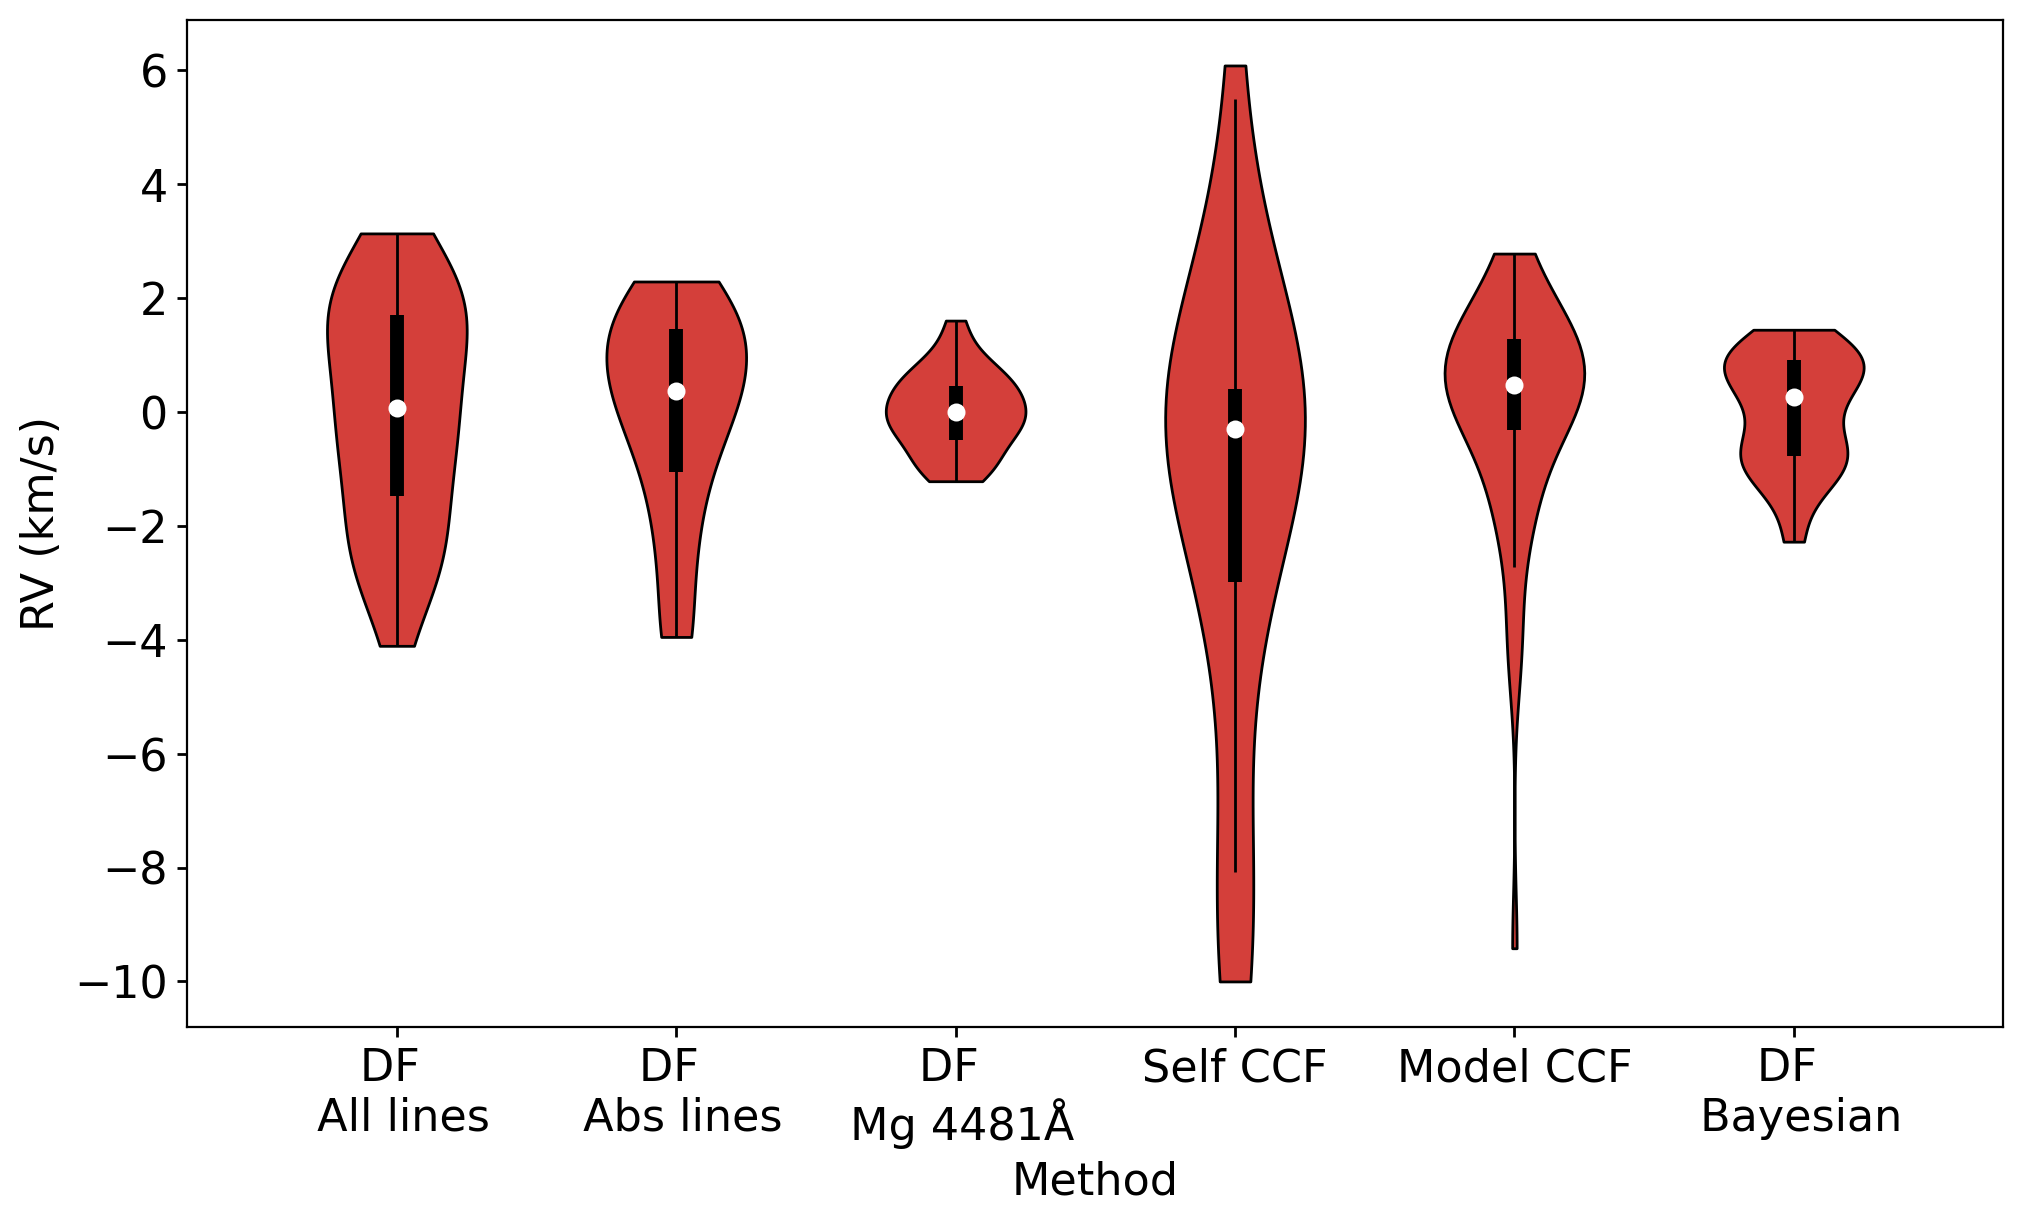

In [83]:
def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value


def set_axis_style(ax, labels):
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_ylabel('RV (km/s)')
    ax.set_xlabel("Method")

#figure(figsize=(10, 8), dpi=400) format for adding the 
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), dpi= 200,sharey=True,constrained_layout=True)

#ax.set_title('Violin plot')
parts = ax.violinplot(
        voigt_data, showmeans=False, showmedians=False,
        showextrema=False)

for pc in parts['bodies']:
    pc.set_facecolor('#D43F3A')
    pc.set_edgecolor('black')
    pc.set_alpha(1)

# Initialize lists to store quartiles and adjacent values for each column
all_quartile1 = []
all_medians = []
all_quartile3 = []
all_whiskers_min = []
all_whiskers_max = []

# Iterate over each column and calculate quartiles and adjacent values
for column in voigt_data:
    q1, median, q3 = np.percentile(column, [25, 50, 75])
    all_quartile1.append(q1)
    all_medians.append(median)
    all_quartile3.append(q3)
    whiskers = adjacent_values(np.sort(column), q1, q3)
    all_whiskers_min.append(whiskers[0])
    all_whiskers_max.append(whiskers[1])

inds = np.arange(1, len(all_medians) + 1)
ax.scatter(inds, all_medians, marker='o', color='white', s=30, zorder=3)
ax.vlines(inds, all_quartile1, all_quartile3, color='k', linestyle='-', lw=5)
ax.vlines(inds, all_whiskers_min, all_whiskers_max, color='k', linestyle='-', lw=1)

# set style for the axes
labels = ['DF \n All lines', 'DF \n Abs lines', 'DF \n Mg 4481Å', "Self CCF", 'Model CCF','DF \n Bayesian']
set_axis_style(ax, labels)

#plt.subplots_adjust(bottom=0.15, wspace=0.05)
#plt.savefig("/data/wdplanetary/omri/Output/violinplots/voigt_comparisons.pdf")
plt.show()



In [ ]:
mg4481 = np.loadtxt("/data/wdplanetary/omri/Output/resultfiles/voigt_fitting_mg4481.txt",delimiter=',')
crosscorr_bluespec = np.loadtxt("/data/wdplanetary/omri/Output/resultfiles/crosscorrRV_bluespec_results.txt",delimiter=',')
crosscorr_model = np.loadtxt("/data/wdplanetary/omri/Output/resultfiles/crosscorrRV_model_mg4481_results.txt",delimiter=',')
data = np.array((mg4481[:, 1] - np.mean(mg4481[:, 1]), crosscorr_bluespec[:, 1], crosscorr_model[:, 1] - np.mean(crosscorr_model[:, 1])))

def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value


def set_axis_style(ax, labels):
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_ylabel('Radial Velocity variation (km/s)')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6), sharey=True)

#ax.set_title('Violin plot')
parts = ax.violinplot(
        data, showmeans=False, showmedians=False,
        showextrema=False)

for pc in parts['bodies']:
    pc.set_facecolor('#D43F3A')
    pc.set_edgecolor('black')
    pc.set_alpha(1)

# Initialize lists to store quartiles and adjacent values for each column
all_quartile1 = []
all_medians = []
all_quartile3 = []
all_whiskers_min = []
all_whiskers_max = []

# Iterate over each column and calculate quartiles and adjacent values
for column in data:
    q1, median, q3 = np.percentile(column, [25, 50, 75])
    all_quartile1.append(q1)
    all_medians.append(median)
    all_quartile3.append(q3)
    whiskers = adjacent_values(np.sort(column), q1, q3)
    all_whiskers_min.append(whiskers[0])
    all_whiskers_max.append(whiskers[1])

inds = np.arange(1, len(all_medians) + 1)
ax.scatter(inds, all_medians, marker='o', color='white', s=30, zorder=3)
ax.vlines(inds, all_quartile1, all_quartile3, color='k', linestyle='-', lw=5)
ax.vlines(inds, all_whiskers_min, all_whiskers_max, color='k', linestyle='-', lw=1)

# set style for the axes
labels = ['Voigt fit on Mg 4481 line', 'Self Cross-Correlation', "Model Cross-Correlation"]
set_axis_style(ax, labels)

plt.savefig("/data/wdplanetary/omri/Output/violinplots/voigt_vs_crosscorr.pdf")
#plt.subplots_adjust(bottom=0.15, wspace=0.05)
plt.show()

In [ ]:
mg4481 = pd.read_csv(file_path, delimiter='\t', encoding='utf-8')

data = np.array((mg4481[:, 1] - np.mean(mg4481[:, 1]), crosscorr_bluespec[:, 1], crosscorr_model[:, 1] - np.mean(crosscorr_model[:, 1])))

def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value


def set_axis_style(ax, labels):
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_ylabel('Radial Velocity variation (km/s)')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6), sharey=True)

#ax.set_title('Violin plot')
parts = ax.violinplot(
        data, showmeans=False, showmedians=False,
        showextrema=False)

for pc in parts['bodies']:
    pc.set_facecolor('#D43F3A')
    pc.set_edgecolor('black')
    pc.set_alpha(1)

# Initialize lists to store quartiles and adjacent values for each column
all_quartile1 = []
all_medians = []
all_quartile3 = []
all_whiskers_min = []
all_whiskers_max = []

# Iterate over each column and calculate quartiles and adjacent values
for column in data:
    q1, median, q3 = np.percentile(column, [25, 50, 75])
    all_quartile1.append(q1)
    all_medians.append(median)
    all_quartile3.append(q3)
    whiskers = adjacent_values(np.sort(column), q1, q3)
    all_whiskers_min.append(whiskers[0])
    all_whiskers_max.append(whiskers[1])

inds = np.arange(1, len(all_medians) + 1)
ax.scatter(inds, all_medians, marker='o', color='white', s=30, zorder=3)
ax.vlines(inds, all_quartile1, all_quartile3, color='k', linestyle='-', lw=5)
ax.vlines(inds, all_whiskers_min, all_whiskers_max, color='k', linestyle='-', lw=1)

# set style for the axes
labels = ['Voigt fit on Mg 4481 line', 'Self Cross-Correlation', "Model Cross-Correlation"]
set_axis_style(ax, labels)

plt.savefig("/data/wdplanetary/omri/Output/violinplots/voigt_vs_crosscorr.pdf")
#plt.subplots_adjust(bottom=0.15, wspace=0.05)
plt.show()

In [ ]:
#Violin plot for each line:
y = filtered_rvarray - np.mean(filtered_rvarray)
plt.violinplot(y, showmeans=False)
plt.show()




#Gaussian fitting plot

plt.errorbar(times, rvs, yerr=rverrs,fmt = '.k')
plt.xlabel("Time")
plt.ylabel("Radial Velocity km/s")
plt.title("WD1929+012 Radial Velocity variations using Gaussian fits")
plt.gcf().autofmt_xdate()
#plt.xticks(rotation=45)
#plt.tight_layout()
#plt.ylim(30,50)
plt.show()

In [ ]:
#Now attempt to make a periodogram of these results

data = np.loadtxt("/data/wdplanetary/omri/Output/resultfiles/mike_voigt_fitting_ca_mg.txt",delimiter=',')
v = data[:, 1] - np.mean(data[:, 1])
t = data[:, 0]
errs = data[:, 2]
print(data)
#errs = np.full(len(v),0.5)
#frequency,power = LombScargle(tdays, v, errs).autopower()
frequencies = np.linspace(0.001,10,10000)
#frequencies = np.linspace(1/1000, 50, num=400000)

power = LombScargle(t, v,errs).power(frequencies)
normalized_power = power/np.max(power)

fig, (ax_t, ax_w) = plt.subplots(2, 1, constrained_layout=True)
ax_t.errorbar(t, v, yerr=errs, fmt='b+', label='Data with Errors')
ax_t.set_xlabel('Time [days]')
ax_t.legend()

ax_w.plot(frequencies, normalized_power)
ax_w.set_xlabel('Angular frequency [rad/days]')
ax_w.set_ylabel('Normalized amplitude')
plt.show()


# Identify significant peaks (you can set your own threshold here)
threshold = 0.5  # Adjust as needed
significant_peaks = frequencies[normalized_power > threshold]

# Estimate false alarm rate for each peak
false_alarm_rates = []
for peak_freq in significant_peaks:
    # Use your preferred method to estimate false alarm rate here
    # Example: Monte Carlo simulations
    num_simulations = 1000  # Adjust as needed
    peak_heights_simulated = []
    for _ in range(num_simulations):
        simulated_data = np.random.normal(0, 1, len(t))  # Generate random noise
        simulated_power = LombScargle(t, simulated_data, errs).power([peak_freq])
        peak_heights_simulated.append(simulated_power[0])
    false_alarm_rate = np.sum(peak_heights_simulated >= normalized_power[np.where(frequencies == peak_freq)]) / num_simulations
    false_alarm_rates.append(false_alarm_rate)

# Print significant peaks and their corresponding false alarm rates
print("Significant Peaks:")
for i, freq in enumerate(significant_peaks):
    print(f"Frequency: {freq}, False Alarm Rate: {false_alarm_rates[i]}")


In [ ]:
#model data periodogram
rand = np.random.default_rng(402)
t = 1000 * rand.random(30)
dy = 0.3
y = np.sin(0.2* 2 * np.pi * t) + dy * rand.standard_normal(30)

frequency = np.linspace(0.1, 1, 10000)
power = LombScargle(t, y, dy).power(frequency)

fig, (ax_t, ax_w) = plt.subplots(2, 1, constrained_layout=True)
ax_t.errorbar(t, y, yerr=dy, fmt='b+', label='Data with Errors')
ax_t.set_xlabel('Time [days]')
ax_t.legend()

ax_w.plot(frequency, power)
ax_w.set_xlabel('Angular frequency [rad/days]')
ax_w.set_ylabel('Normalized amplitude')
plt.show()

In [ ]:
#finding wavelength resolution of SALT
resolving_power = 13000
wav = 4800
deltawav = (wav)/resolving_power
v = (deltawav/(wav)) * 299792
print("This resolving power leads to a minimum resolved radial velocity change of " + str(v))